# Run the `pattern_by_example` Paraphrase generation workflow

Main page to run the workflow on the PSA.csv seed dataset. We will run the workflow for 2 round as stated in [Jorge et al](https://link.springer.com/chapter/10.1007/978-3-031-07472-1_15).

In the present workflow, we execute one round. We employ GPT to generate a set of **12** paraphrases for every seed utterance, as opposed to the baseline pattern_by_example 3 paraphrases per seed.

In [3]:
import os
import pathlib
import json

# let's just make sure we are at the root
os.chdir(pathlib.Path().absolute().parent)
current_directory = os.getcwd()
new_directory = f"{current_directory}/Jorge_paper_replication"
os.chdir(new_directory)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/jovyan/test/Jorge_paper_replication


In [11]:
import random
import requests
from collections import Counter
from itertools import cycle
import time
import math
import warnings
import pandas as pd
import numpy as np
import stanza
import seaborn as sns
from tqdm import tqdm
from transformers import logging
from bert_score import score
import matplotlib.pyplot as plt
from termcolor import colored

from lib import metrics
from lib import utility as utlty
from lib import prompts_utility
from lib import gpt_utility

logging.set_verbosity_error()#suppressing the display of warning messages.
warnings.simplefilter(action='ignore', category=FutureWarning)#suppress Pandas Future warning

In [3]:
# Import stanza model
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency', tokenize_no_ssplit=True)

2023-08-23 12:02:44 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-08-23 12:02:44 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2023-08-23 12:02:44 INFO: Using device: cuda
2023-08-23 12:02:44 INFO: Loading: tokenize
2023-08-23 12:02:47 INFO: Loading: pos
2023-08-23 12:02:47 INFO: Loading: constituency
2023-08-23 12:02:48 INFO: Done loading processors!


# OpenAI credentials
Replace with your GPT API key and endpoint URL

In [4]:
# Replace with your personal GPT API key
API_KEY = ""

gpt_utility.define_credential(API_KEY)

# Pattern Selection Strategy
---
To support the selection of patterns, our experiment code will build a pattern frequency table. This involves analyzing each unique syntax pattern and counting the number of paraphrases associated with each pattern in the corpus. The next step is to select a subset of **n** patterns as our target patterns. We will achieve this by implementing a pattern selection strategy.

In this experiment, we have two choices for the strategy: either selecting the **least-frequent** patterns (<span style="color:blue;">***bottom***</span>) or the **most-frequent** patterns (<span style="color:blue;">***top***</span>). The choice of strategy will significantly impact the paraphrase generation step, resulting in different prompts for our experiment.

#### <div style="background-color: lightblue; padding: 10px;">Step 1 - Data preparation: Paraphrase Template Extraction and Syntax Pattern Frequency Preparation</div>
The purpose of this cell is to retrieve paraphrase templates for the correct paraphrases generated in the `bootstrap_round.ipynb`, specifically focusing on those that are semantically related and non-duplicate. These paraphrases, referred to as 'correct' throughout this analysis, originate from the bootstrap round stored in **output/bootstrap-clean.csv** file. We extract their corresponding templates `'paraphrase_template'` and organize this information into a DataFrame. The DataFrame consists of: a columns the paraphrases and another for their associated syntax templates, and additional columns. The extracted information, including input utterance, utterance template, seed ID, paraphrase value, paraphrase template, BERT score, and TED score, is organized into a new DataFrame, making it easier to analyze and work with the paraphrase templates.
This organized structure serves as the foundation for constructing a frequency table that tracks the occurrences of each syntax pattern. This table becomes instrumental in guiding the pattern selection strategy for subsequent stages. 

In [5]:
input_file = f"{os.getcwd()}/output/bootstrap-clean.csv"#test_data
df = pd.read_csv(input_file)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns}")
df.head()

Shape: (1188, 10)
Columns: Index(['input_utterance', 'intent', 'parameters', 'utterance_template',
       'source', 'seed_id', 'paraphrase_value', 'paraphrase_template',
       'bertscore', 'ted'],
      dtype='object')


,input_utterance,intent,parameters,utterance_template,source,seed_id,paraphrase_value,paraphrase_template,bertscore,ted
0,Terminate i-a541 now,EndEC2Instance,"[['VM', 'i-a541']]",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),ParaQuality,1,End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),0.947383,5.0
1,Search for cooking videos,SearchWeb,"[['query', 'cooking videos']]",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,2,Find videos on how to cook,( S ( VP ( VB ) ( NP ) ) ),0.917345,4.0
2,Find most popular photos tagged #LOVE,SearchWeb,"[['Tag', '#LOVE']]",( S ( S ( VP ) ) ( VP ( VBP ) ) ),ParaQuality,3,Discover the trending pictures labeled #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) ),0.954254,0.0
3,Search for a few nice photos matching Opera Ho...,SearchWeb,"[['size', '1024px * 768px'], ['query', 'Opera ...",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,4,Find some beautiful pictures that match Opera ...,( S ( VP ( VB ) ( NP ) ) ( . ) ),0.928975,5.0
4,Are the burglar alarms in the office malfuncti...,CheckDevice,"[['location', 'office']]",( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,ParaQuality,5,Do the burglar alarms in the office have a mal...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,0.969968,6.0


#### <div style="background-color: lightblue; padding: 10px;">Step 2 - Extracting Frequency Table of Syntax Templates from Paraphrases</div>
In this phase of our pipeline, our attention turns to constructing a **frequency table** that captures the prevalence of syntax templates within our paraphrase dataset. Subsequently, these collected templates are aggregated and set to generate a frequency table encompassing all syntax patterns across the entire collection of paraphrases, utilizing the `get_template_frequency_table` function.

Through the application of a counter-based approach, we create a comprehensive pattern frequency table, enabling us to quantify the distribution and occurrence of each syntax pattern inherent in the paraphrase dataset. This frequency table serves as a cornerstone for our upcoming stages of paraphrase generation, guiding the GPT model towards selected syntactic templates.

##### <div style="background-color: lightblue; padding: 10px;">Step 2.1. Get Syntax templates frequency</div>

The `get_template_frequency_table` function calculates the frequency of each unique syntax template in a DataFrame's **paraphrase_template** column. It also constructs a dictionary that associates each syntax template with a list of paraphrase values sharing that template. This function is useful for analyzing the distribution of syntax patterns within paraphrase data and for exploring paraphrase values corresponding to specific syntax templates. The `template_count` parameter determines the number of top syntax templates to consider.

In [6]:
def get_template_frequency_table(df):
    """
    Calculate the frequency of each syntax template in the 'paraphrase_template' column of the input DataFrame
    and create a dictionary mapping each template to a list of paraphrase values that share the same template.

    :args
        df (pandas.DataFrame): The input DataFrame containing columns: 'paraphrase_value', 'paraphrase_template'.

    :returns
        tuple: A tuple containing two dictionaries:
            - template_frequency (dict): A dictionary mapping each syntax template to its frequency count.
            - template_paraphrases (dict): A dictionary mapping each syntax template to a list of paraphrase values
                                          that share the same template.
    """
    template_counter = Counter()
    template_paraphrases = {}

    for index, row in df.iterrows():
        template = row['paraphrase_template']
        paraphrase_value = row['paraphrase_value']

        template_counter[template] += 1
        if template not in template_paraphrases:
            template_paraphrases[template] = [paraphrase_value]
        else:
            template_paraphrases[template].append(paraphrase_value)

    return dict(template_counter), template_paraphrases

In [7]:
tmplt_count, related_paraphrases = get_template_frequency_table(df)
len(related_paraphrases)

230

##### <div style="background-color: lightblue; padding: 10px;">Step 2.2. Selection strategy</div>
The `select_target_templates` function allows you to choose a subset of syntax templates from a provided frequency table. You can specify the number of templates to select (**top_n**) and the selection strategy (**top** or **bottom**). The function returns a list of the selected syntax templates based on the chosen strategy and their corresponding frequencies in the input frequency table. This function can be valuable for identifying and focusing on specific syntax patterns that are more prevalent or less common within a dataset, aiding in further analysis and downstream processing.

In [8]:
def select_target_templates(template_frequency, top_n=2, strategy="bottom"):
    """
    Select a subset of n target patterns based on the pattern frequency table and the given strategy.

    :args
        template_frequency (dict): A dictionary containing the frequency of each syntax template.
        n (int): The number of templates to return.
        strategy (str): The strategy to use for selecting templates. Can be "top" or "bottom".

    :returns
        selected_templates (list): A list of selected syntax templates.
    """
    if strategy in ["top","bottom"]:
        sorted_patterns = sorted(template_frequency.items(), key=lambda item: item[1], reverse=(strategy == strategy))
    else:
        raise ValueError("Invalid strategy. Use 'top' or 'bottom'.")

    selected_patterns = [pattern for pattern, _ in sorted_patterns[:top_n]]

    return selected_patterns

In [9]:
test_select = select_target_templates(tmplt_count,2,"bottom")
test_select

['( S ( VP ( VB ) ( NP ) ) )',
 '( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ( NP ) ) ( . ) )']

##### <div style="background-color: lightblue; padding: 10px;">Step 2.3. Retrieve Paraphrases Associated with the Chosen Syntax Templates</div>

Obtain a collection of paraphrases that are linked to the syntax templates chosen in the previous step. This step serves to construct latter the prompt for GPT, guiding its generation process. By incorporating paraphrases exhibiting the chosen syntax templates, this prompt aids in directing GPT toward generating outputs that align with the specified templates.

The `get_related_paraphrases` function retrieves a random list of paraphrases that correspond to a given set of selected syntax templates. It takes as input a list of selected template keys, a dictionary that maps each syntax template to a list of associated paraphrase values, and an integer n representing the desired number of paraphrases to retrieve for each selected template.

In [10]:
def get_related_paraphrases(selected_templates, template_paraphrases, n=1):
    """
    Retrieve a random list of paraphrases associated with the specified selected templates.
    
    :args
        selected_templates: A list of selected template keys from which to extract the list of paraphrases.
        template_paraphrases: A dictionary mapping each syntax template to a list of paraphrase values that share the same template.
        n: The number of paraphrases to return for each selected template.

    :return
        A list of n random paraphrases for each selected template.
    """
    related_paraphrases = []
    for template in selected_templates:
        if template in template_paraphrases:
            paraphrases_for_template = template_paraphrases[template]
            n_to_select = min(n, len(paraphrases_for_template))
            selected_paraphrases = random.sample(paraphrases_for_template, n_to_select)
            related_paraphrases.extend(selected_paraphrases)
    return related_paraphrases

In [15]:
test = get_related_paraphrases(test_select,related_paraphrases,1)
test

['include this musician called Kirk Hammett in my Party playlist',
 'Can you tell me the schedule for Crime and Punishment U.S.A.?']

In [16]:
def retrieve_data_for_input(input_utterance,df,selected_templates,related_paraphrases):
    """
    Retrieve specific dependency values from the DataFrame based on the given input utterance.

    :args
        input_utterance (str): The input utterance for which data is required.
        df (pandas.DataFrame): The DataFrame containing the data.
        selected_templates (List[string]): list of selected syntax templates.
        related_paraphrases (List[string]): List of paraphrases associated with the specified selected templates.

    :returns
        dict: A dictionary containing the following extracted values:
            - 'input_utterance': The input utterance.
            - 'intent': The intent associated with the input utterance.
            - 'parameters': The parameters associated with the input utterance.
            - 'utterance_template': The utterance template.
            - 'source': The source of the input utterance.
            - 'seed_id': The seed ID associated with the input utterance.
            - 'selected_templates': The selected templates for the current round
            - 'selected_templates_related_paraphrases': List of paraphrases that share the same pattern as one of the elements in the selected_templates list.
    """
    req_data = df.loc[df['input_utterance'] == input_utterance, ['intent', 'parameters', 'utterance_template', 'source', 'seed_id']].values
    ret_data = {
        'input_utterance': input_utterance,
        'intent': req_data[0][0],
        'parameters': req_data[0][1],
        'utterance_template': req_data[0][2],
        'source': req_data[0][3],
        'seed_id': req_data[0][4],
        'selected_templates': selected_templates.copy(),
        'selected_templates_related_paraphrases': related_paraphrases.copy()
    }
    return ret_data

# <div style="background-color: lightgreen; padding: 10px;">Main</div>

##### Compare syntax of paraphrase with Selected pattern
Examine each generated paraphrase to determine whether its syntax aligns with the chosen pattern. Since we are operating within a patterns-by-example workflow, it is essential that the generated paraphrases exhibit syntactic structures that are comparable to the syntax patterns of the selected templates.

In [17]:
def check_syntax_compliance(paraphrase_template, selected_templates,df_row,key,ted_threshold=2):
    """
    Compute the Tree Edit Distance (TED) scores between a paraphrase_template and a list of syntax templates.

    :args
        paraphrase_template: The paraphrase syntax template for which TED scores are computed.
        selected_templates: List of selected syntax templates to compute TED scores against.
        df_row: A dictionary containing the data for the current row.
            Keys: 'input_utterance', 'intent', 'parameters', 'utterance_template',
            'source', 'seed_id', 'selected_templates', 'selected_templates_related_paraphrases'
        key: a string to name the column: p1, p2 or pn -> key_is_similar == p1_is_similar
        ted_threshold: The threshold value for TED scores. Default is 2.


    :return
        A dictionary containing the original data (df_row) along with additional information:
            - ted_to_selected_templates: A dictionary with TED scores for each selected template.
            - is_similar: A boolean indicating if any TED score is below the specified threshold.
    """
    ted_scores = {}
    for selected_t in selected_templates:
        ted_score = utlty.syn_utility.compute_tree_edit_distance(paraphrase_template, selected_t)
        ted_scores[selected_t] = ted_score

    #  checks if TED with any of the selected tmeplates is below the specified ted_threshold
    below_threshold = any(value <= ted_threshold for value in ted_scores.values())
    df_row[f'{key}_ted_to_selected_templates'] = ted_scores.copy()
    df_row[f'{key}_is_similar'] = below_threshold
    
    return df_row


#### <div style="background-color: lightgreen; padding: 10px;">Run the workflow</div>

In [20]:
# Set the number of rounds (r) for the data collection process
num_rounds = 2# In the paper by Jorge et al., they gathered 24 paraphrases for each seed.

# Set the number of paraphrases to generate per prompt
num_paraphrases = 12

ted_threshold = 3

#--------- Initialize X and Y for Round 1 ---------
# X = seed_utterances
X = df['input_utterance'].unique().tolist()

# Y = input_paraphrase_corpus i.e. all correct parparhases from bootstrap_round.ipynb
# syntax_templates_counter i.e. all syntax patterns from bootstrap_round.ipynb and their occurences, help build frequency table
syntax_templates_counter, Y = get_template_frequency_table(df)

# Replace the following parameters with your predefined configuration:
cnfg_title = "Patterns-by-example Workflow Configuration"
print(colored(cnfg_title, 'green'))
print(colored("-" * len(cnfg_title), 'green'))
print()
# print(f"- Number of Workflow Rounds: {num_rounds}")
print(colored(f"- Number of paraphrases to generate per prompt: {num_paraphrases}",'green'))
print(colored(f"- Prompt type: Patterns-by-example", 'green'))
print()

# The "round_2_df" dataframe will exclusively hold the paraphrases generated in Round 2 through this current script.
new_column_names = ['input_utterance', 'intent', 'parameters', 'utterance_template', 'source', 'seed_id']
round_2_df = pd.DataFrame(columns=new_column_names)

# Step 1: Selection of Patterns and Retrieval of Related Paraphrases
selected_templates = select_target_templates(syntax_templates_counter,2,"bottom")# Select top 2 syntax templates

# print(colored('hello', 'red'), colored('world', 'green'))
start_time = time.time()

for r in tqdm(range(1, num_rounds + 1), desc="Rounds"):
    print(f"Round {r}:")
    print()
    
    # Step 1: Paraphrase generation (using the OpenAI API)
    for seed_utterance in tqdm(X, desc="Iterated seed utterances", leave=False):
         # Step 2:  Crafting Prompts for each seed_utterance
        related_paraphrases = get_related_paraphrases(selected_templates,Y,1)# get 1 paraphrases for each syntax templates
        
        # prompt = prompts_utility.get_taboo_patterns_prompt(seed_utterance,related_paraphrases)
        prompt = prompts_utility.get_patterns_by_example_prompt(seed_utterance,related_paraphrases,n=num_paraphrases)
    
        # Step 3: Invoke GPT with the built prompt
        # To prevent the occurrence of nan values, we set a maximum attempt limit.
        # This issue arises from GPT's token limit, particularly when the seed utterances are lengthy.
        # When generating more than 5 paraphrases, incomplete generation can happen.
        # For instance, if we aim to generate 12 paraphrases, we might end up with only 6,
        # with the remainder of the list containing nan values.
        attempts = 0
        max_attempts = 5
        collected_num_parpahrases = []# empty list to collect all paraphrases generated during the seveal attempts

        while attempts < max_attempts:
            paraphrases = gpt_utility.generate_paraphrases_with_retry(prompt,10)
            paraphrases = utlty.checkgpt_generation_not_empty(paraphrases,num_paraphrases)#check if GPT returned num_paraphrases paraphrases
            
            try:
                # Check if the paraphrases list contains at least one nan value
                if any(pd.isna(p) for p in paraphrases):
                    # Call the checkgpt_generation_not_empty function and collect num_parpahrases
                    collected_num_parpahrases.extend([p for p in paraphrases if not pd.isna(p)])  # add non nan candidates to the set
                    collected_num_parpahrases = list(set(collected_num_parpahrases))  # remove duplicates from the collected paraphrases
            
                    if len(collected_num_parpahrases) >= 12:
                        # Randomly select num_paraphrases paraphrases from the collected set
                        paraphrases = random.sample(collected_num_parpahrases, num_paraphrases)
                        break
                    else:
                        print(f"Attempt {attempts+1}: Some paraphrases contain nan values, retrying...")
                else:
                    break
            except ValueError as e:
                print(f"Attempt {attempts+1}: Some paraphrases contain nan values, retrying...")

            attempts += 1  # Increment the attempts counter

        # Step 4: Retrieve dependency values for the current utterance
        new_row = retrieve_data_for_input(seed_utterance,df,selected_templates,related_paraphrases)
        for i, paraphrase in enumerate(paraphrases):
            key = f"p{i+1}"
    
            # Append current paraphrase
            new_row[key] = paraphrase
    
            # Extract and append the syntax pattern template of the current paraphrase.
            paraphrase_syntax_template,_,_ = utlty.extract_syntax_pattern(nlp, paraphrase)
            new_row[f"{key}_template"] = paraphrase_syntax_template
            
            # Verify whether the syntax templates of the generated paraphrases align with the selected_templates.
            new_row = check_syntax_compliance(paraphrase_syntax_template, selected_templates,new_row,key,ted_threshold=ted_threshold)
            
        # Verify whether the syntax templates of the generated paraphrases align with the selected_templates.
        new_row_df = pd.DataFrame([new_row])
        round_2_df = pd.concat([round_2_df, new_row_df], ignore_index=True)
    
    print()
    print(f"Paraphrase generation for Round {r} has been successfully completed.")
    print()
    
    # Save the df_bootstrap to a file to ensure data persistence.
    # In case of any errors, this step prevents the need to restart all rounds from the beginning.
    path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/pattern_by_example_{num_paraphrases}-raw-round{r}.csv")
    round_2_df.to_csv(path_to_plot_file, index=False)

# Display the execution time, which can be valuable for comparison with crowdsourcing execution times.
end_time = time.time()
execution_time = end_time - start_time
print(colored('Execution time: ', 'green'), colored(f"{execution_time:.2f}", 'red'),colored(' seconds', 'green'))

print(round_2_df.shape)
round_2_df.head()

Patterns-by-example Workflow Configuration
------------------------------------------

- Number of paraphrases to generate per prompt: 12
- Prompt type: Patterns-by-example



Rounds:   0%|          | 0/2 [00:00<?, ?it/s]

Round 1:




Iterated seed utterances:   0%|          | 0/51 [00:00<?, ?it/s]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:   2%|▏         | 1/51 [00:32<27:12, 32.64s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:   4%|▍         | 2/51 [00:41<15:23, 18.85s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:   6%|▌         | 3/51 [02:38<50:58, 63.73s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:   8%|▊         | 4/51 [03:05<38:21, 48.98s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  10%|▉         | 5/51 [04:37<49:37, 64.73s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  12%|█▏        | 6/51 [05:18<42:21, 56.47s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  14%|█▎        | 7/51 [06:22<43:15, 58.99s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  16%|█▌        | 8/51 [08:04<51:58, 72.53s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  18%|█▊        | 9/51 [09:01<47:25, 67.76s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  20%|█▉        | 10/51 [09:44<41:08, 60.20s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  22%|██▏       | 11/51 [09:57<30:31, 45.78s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  24%|██▎       | 12/51 [10:09<23:04, 35.51s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  25%|██▌       | 13/51 [10:19<17:29, 27.63s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  27%|██▋       | 14/51 [10:37<15:21, 24.90s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  29%|██▉       | 15/51 [11:24<18:48, 31.36s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  31%|███▏      | 16/51 [11:37<15:10, 26.02s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  33%|███▎      | 17/51 [13:00<24:28, 43.19s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  35%|███▌      | 18/51 [18:04<1:06:46, 121.40s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  37%|███▋      | 19/51 [18:14<46:54, 87.95s/it]   

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  39%|███▉      | 20/51 [19:41<45:15, 87.59s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  41%|████      | 21/51 [20:38<39:16, 78.56s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  43%|████▎     | 22/51 [21:31<34:10, 70.69s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  45%|████▌     | 23/51 [23:18<38:08, 81.72s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  47%|████▋     | 24/51 [24:23<34:32, 76.75s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  49%|████▉     | 25/51 [25:17<30:17, 69.90s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  51%|█████     | 26/51 [26:38<30:29, 73.17s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.



Iterated seed utterances:  53%|█████▎    | 27/51 [29:10<38:43, 96.81s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  55%|█████▍    | 28/51 [30:01<31:49, 83.02s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  57%|█████▋    | 29/51 [31:08<28:45, 78.45s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  59%|█████▉    | 30/51 [34:15<38:49, 110.93s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  61%|██████    | 31/51 [34:44<28:45, 86.29s/it] 

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  63%|██████▎   | 32/51 [37:54<37:10, 117.41s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  65%|██████▍   | 33/51 [38:07<25:47, 85.97s/it] 

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  67%|██████▋   | 34/51 [38:38<19:42, 69.53s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  69%|██████▊   | 35/51 [39:26<16:49, 63.06s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.



Iterated seed utterances:  71%|███████   | 36/51 [41:39<21:03, 84.23s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Attempt 2: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 2 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  73%|███████▎  | 37/51 [46:04<32:16, 138.31s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  75%|███████▍  | 38/51 [46:51<24:03, 111.01s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.



Iterated seed utterances:  76%|███████▋  | 39/51 [48:51<22:43, 113.64s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  78%|███████▊  | 40/51 [50:15<19:11, 104.71s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  80%|████████  | 41/51 [53:11<21:02, 126.29s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  82%|████████▏ | 42/51 [54:24<16:30, 110.04s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  84%|████████▍ | 43/51 [57:24<17:30, 131.28s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  86%|████████▋ | 44/51 [57:43<11:22, 97.53s/it] 

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  88%|████████▊ | 45/51 [59:45<10:28, 104.72s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  90%|█████████ | 46/51 [1:00:32<07:17, 87.45s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Attempt 2: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 2 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  92%|█████████▏| 47/51 [1:03:31<07:40, 115.05s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  94%|█████████▍| 48/51 [1:03:40<04:09, 83.08s/it] 

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  96%|█████████▌| 49/51 [1:04:19<02:19, 69.83s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  98%|█████████▊| 50/51 [1:04:43<00:56, 56.10s/it]

Paraphrases generated successfully after 0 attempts.



Rounds:  50%|█████     | 1/2 [1:05:27<1:05:27, 3927.07s/it]                


Paraphrase generation for Round 1 has been successfully completed.

Round 2:




Iterated seed utterances:   0%|          | 0/51 [00:00<?, ?it/s]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:   2%|▏         | 1/51 [00:37<31:01, 37.22s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:   4%|▍         | 2/51 [01:03<24:59, 30.60s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:   6%|▌         | 3/51 [02:08<37:18, 46.64s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.



Iterated seed utterances:   8%|▊         | 4/51 [05:48<1:29:52, 114.74s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  10%|▉         | 5/51 [05:59<59:28, 77.58s/it]   

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  12%|█▏        | 6/51 [07:36<1:03:03, 84.09s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  14%|█▎        | 7/51 [08:07<49:00, 66.84s/it]  

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  16%|█▌        | 8/51 [09:38<53:20, 74.43s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  18%|█▊        | 9/51 [11:44<1:03:26, 90.62s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  20%|█▉        | 10/51 [12:31<52:45, 77.20s/it] 

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  22%|██▏       | 11/51 [12:43<38:09, 57.23s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  24%|██▎       | 12/51 [12:56<28:20, 43.59s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  25%|██▌       | 13/51 [13:33<26:27, 41.77s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  27%|██▋       | 14/51 [14:02<23:18, 37.81s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  29%|██▉       | 15/51 [14:28<20:36, 34.34s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  31%|███▏      | 16/51 [14:51<17:56, 30.75s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  33%|███▎      | 17/51 [15:30<18:57, 33.45s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  35%|███▌      | 18/51 [16:28<22:21, 40.64s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  37%|███▋      | 19/51 [16:57<19:51, 37.22s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  39%|███▉      | 20/51 [18:25<27:06, 52.47s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  41%|████      | 21/51 [18:47<21:35, 43.17s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  43%|████▎     | 22/51 [18:56<16:00, 33.12s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  45%|████▌     | 23/51 [19:23<14:35, 31.28s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  47%|████▋     | 24/51 [21:43<28:41, 63.75s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  49%|████▉     | 25/51 [23:28<32:59, 76.13s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  51%|█████     | 26/51 [24:00<26:16, 63.07s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  53%|█████▎    | 27/51 [25:13<26:19, 65.83s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  55%|█████▍    | 28/51 [25:41<20:55, 54.59s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  57%|█████▋    | 29/51 [26:03<16:28, 44.92s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  59%|█████▉    | 30/51 [29:21<31:44, 90.67s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  61%|██████    | 31/51 [32:08<37:55, 113.78s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  63%|██████▎   | 32/51 [33:03<30:26, 96.15s/it] 

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  65%|██████▍   | 33/51 [33:18<21:32, 71.78s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  67%|██████▋   | 34/51 [33:40<16:06, 56.88s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  69%|██████▊   | 35/51 [33:54<11:39, 43.73s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  71%|███████   | 36/51 [35:28<14:42, 58.84s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  73%|███████▎  | 37/51 [35:55<11:30, 49.33s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  75%|███████▍  | 38/51 [36:57<11:32, 53.31s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  76%|███████▋  | 39/51 [38:40<13:36, 68.01s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  78%|███████▊  | 40/51 [40:01<13:10, 71.89s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  80%|████████  | 41/51 [42:32<15:56, 95.62s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  82%|████████▏ | 42/51 [45:13<17:18, 115.44s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  84%|████████▍ | 43/51 [46:02<12:42, 95.37s/it] 

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  86%|████████▋ | 44/51 [47:49<11:31, 98.84s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.



Iterated seed utterances:  88%|████████▊ | 45/51 [49:51<10:34, 105.82s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  90%|█████████ | 46/51 [50:45<07:31, 90.33s/it] 

Attempt 1: The generated list of paraphrases is empty. Retrying...
Attempt 2: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 2 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  92%|█████████▏| 47/51 [54:47<09:03, 135.81s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  94%|█████████▍| 48/51 [55:29<05:23, 107.67s/it]

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  96%|█████████▌| 49/51 [56:14<02:57, 88.99s/it] 

Paraphrases generated successfully after 0 attempts.



Iterated seed utterances:  98%|█████████▊| 50/51 [57:25<01:23, 83.59s/it]

Paraphrases generated successfully after 0 attempts.
Attempt 1: Some paraphrases contain nan values, retrying...
Paraphrases generated successfully after 0 attempts.



Rounds: 100%|██████████| 2/2 [2:03:59<00:00, 3719.66s/it]                


Paraphrase generation for Round 2 has been successfully completed.

Execution time:  7439.33  seconds
(102, 64)


,input_utterance,intent,parameters,utterance_template,source,seed_id,selected_templates,selected_templates_related_paraphrases,p1,p1_template,...,p12_ted_to_selected_templates,p12_is_similar,p13,p13_template,p13_ted_to_selected_templates,p13_is_similar,p14,p14_template,p14_ted_to_selected_templates,p14_is_similar
0,Terminate i-a541 now,EndEC2Instance,"[['VM', 'i-a541']]",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),ParaQuality,1,"[( S ( VP ( VB ) ( NP ) ) ), ( SQ ( MD ) ( NP ...","[define dfw, Can you find me the most recent s...",Can you terminate i-a541 immediately?,( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ...,...,"{'( S ( VP ( VB ) ( NP ) ) )': 3.0, '( SQ ( MD...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Search for cooking videos,SearchWeb,"[['query', 'cooking videos']]",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,2,"[( S ( VP ( VB ) ( NP ) ) ), ( SQ ( MD ) ( NP ...","[Find videos on cooking, Can you find me a cop...",Look up videos about cooking,( S ( VP ( VB ) ( PRT ) ( NP ) ) ),...,"{'( S ( VP ( VB ) ( NP ) ) )': 6.0, '( SQ ( MD...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Find most popular photos tagged #LOVE,SearchWeb,"[['Tag', '#LOVE']]",( S ( S ( VP ) ) ( VP ( VBP ) ) ),ParaQuality,3,"[( S ( VP ( VB ) ( NP ) ) ), ( SQ ( MD ) ( NP ...",[list the airlines that fly from boston to atl...,Discover the top-rated images with the #LOVE tag,( S ( VP ( VB ) ( NP ) ( PP ) ) ),...,"{'( S ( VP ( VB ) ( NP ) ) )': 6.0, '( SQ ( MD...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Search for a few nice photos matching Opera Ho...,SearchWeb,"[['size', '1024px * 768px'], ['query', 'Opera ...",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,4,"[( S ( VP ( VB ) ( NP ) ) ), ( SQ ( MD ) ( NP ...",[find showtimes for the movie The Caretaker at...,Look up some nice Opera House pictures with di...,( S ( VP ( VB ) ( PRT ) ( NP ) ) ( . ) ),...,"{'( S ( VP ( VB ) ( NP ) ) )': 6.0, '( SQ ( MD...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Are the burglar alarms in the office malfuncti...,CheckDevice,"[['location', 'office']]",( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,ParaQuality,5,"[( S ( VP ( VB ) ( NP ) ) ), ( SQ ( MD ) ( NP ...",[Drop a message to Phil indicating that I've g...,Are the alarms in the office for burglars not ...,( SQ ( VBP ) ( NP ( NP ) ( PP ) ( PP ) ) ( RB ...,...,"{'( S ( VP ( VB ) ( NP ) ) )': 6.0, '( SQ ( MD...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Verify whether the DataFrame contains columns that result from undesired GPT-generated output.
desired_columns = [
    'input_utterance', 'intent', 'parameters', 'utterance_template','source', 'seed_id', 'selected_templates',
    'selected_templates_related_paraphrases', 'p1', 'p1_template',
    'p1_ted_to_selected_templates', 'p1_is_similar', 'p2', 'p2_template',
    'p2_ted_to_selected_templates', 'p2_is_similar', 'p3', 'p3_template',
    'p3_ted_to_selected_templates', 'p3_is_similar', 'p4', 'p4_template',
    'p4_ted_to_selected_templates', 'p4_is_similar', 'p5', 'p5_template',
    'p5_ted_to_selected_templates', 'p5_is_similar', 'p6', 'p6_template',
    'p6_ted_to_selected_templates', 'p6_is_similar', 'p7', 'p7_template',
    'p7_ted_to_selected_templates', 'p7_is_similar', 'p8', 'p8_template',
    'p8_ted_to_selected_templates', 'p8_is_similar', 'p9', 'p9_template',
    'p9_ted_to_selected_templates', 'p9_is_similar', 'p10', 'p10_template',
    'p10_ted_to_selected_templates', 'p10_is_similar', 'p11',
    'p11_template', 'p11_ted_to_selected_templates', 'p11_is_similar',
    'p12', 'p12_template', 'p12_ted_to_selected_templates', 'p12_is_similar'
]

if len(round_2_df.columns) > len(desired_columns):
    columns_to_drop = set(round_2_df.columns) - set(desired_columns)
    print(f"The DataFrame contains the following undesired columns: {columns_to_drop}")
    round_2_df = round_2_df.drop(columns=columns_to_drop)
elif len(round_2_df.columns) < len(desired_columns):
    msg_to_print = "Generation Error: The dataframe is missing certain required columns for further processing in this notebook. "\
                   "Please reexecute the workflow."
    print(colored(msg_to_print, 'red'))

The DataFrame contains the following undesired columns: {'p14_ted_to_selected_templates', 'p14_is_similar', 'p13', 'p14_template', 'p13_is_similar', 'p13_template', 'p14', 'p13_ted_to_selected_templates'}


In [22]:
assert set(round_2_df.columns) == set(desired_columns)

In [23]:
# Save the df to a file
path_to_plot_file = os.path.join(os.getcwd(), f"output/pattern_by_example_12/pattern_by_example_{num_paraphrases}-raw.csv")
round_2_df.to_csv(path_to_plot_file, index=False)
round_2_df.columns

Index(['input_utterance', 'intent', 'parameters', 'utterance_template',
       'source', 'seed_id', 'selected_templates',
       'selected_templates_related_paraphrases', 'p1', 'p1_template',
       'p1_ted_to_selected_templates', 'p1_is_similar', 'p2', 'p2_template',
       'p2_ted_to_selected_templates', 'p2_is_similar', 'p3', 'p3_template',
       'p3_ted_to_selected_templates', 'p3_is_similar', 'p4', 'p4_template',
       'p4_ted_to_selected_templates', 'p4_is_similar', 'p5', 'p5_template',
       'p5_ted_to_selected_templates', 'p5_is_similar', 'p6', 'p6_template',
       'p6_ted_to_selected_templates', 'p6_is_similar', 'p7', 'p7_template',
       'p7_ted_to_selected_templates', 'p7_is_similar', 'p8', 'p8_template',
       'p8_ted_to_selected_templates', 'p8_is_similar', 'p9', 'p9_template',
       'p9_ted_to_selected_templates', 'p9_is_similar', 'p10', 'p10_template',
       'p10_ted_to_selected_templates', 'p10_is_similar', 'p11',
       'p11_template', 'p11_ted_to_selected_temp

##### Counts parparhases that comply with selected templates
In this phase, we assess each of the generated paraphrases, namely 'p1', 'p2', and 'p3', to determine how many of them exhibit a syntax pattern that aligns with the chosen template. The function `count_true_values` counts the number of paraphrases that have a syntax template close to one of the selected templates.

In [24]:
def count_true_values(df, num_similar_columns):
    """
    Count the number of rows where the value is True for each of the '_is_similar' columns.

    :args
        df: pandas DataFrame containing the columns of interest.
        num_similar_columns: Number of '_is_similar' columns.
    :return
        A DataFrame containing the counts for each column.
    """

    counts = {}

    for i in range(1, num_similar_columns + 1):
        column_name = f'p{i}_is_similar'
        rows_is_similar = df[df[column_name]]
        counts[column_name] = rows_is_similar[[column_name]].shape[0]

    return pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])

In [25]:
similarity_counter = count_true_values(round_2_df, num_paraphrases)
print(round_2_df.shape)
#
similarity_counter

(102, 56)


,Count
p1_is_similar,61
p2_is_similar,62
p3_is_similar,62
p4_is_similar,60
p5_is_similar,55
p6_is_similar,52
p7_is_similar,51
p8_is_similar,54
p9_is_similar,33
p10_is_similar,40


In [26]:
# Save the df to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/pattern_by_example_12/patterns-by-example-count-similar-templates-{current_time}.csv")
similarity_counter.to_csv(path_to_plot_file, index=False)

### Compute Bertscore

In [27]:
def calculate_bert_scores(df,templates = ['p1', 'p2', 'p3']):
    """
    Calculate BERTScores for each pair of 'input_utterance' and paraphrases'pX' columns,
    and store the scores in the new columns 'pX_bertscore'.

    :args
        df(pd.DataFrame): The DataFrame containing the 'input_utterance' and 'pX_template' columns.
    """
    
    for template in tqdm(templates):
        col_template = f'{template}_template'
        col_bertscore = f'{template}_bertscore'
        _, _, bert_scores = score(list(df['input_utterance']), list(df[template]), lang="en")
        df[col_bertscore] = bert_scores

In [28]:
# paraphrases_templates = ['p1', 'p2', 'p3']
paraphrases_templates = [f'p{i}' for i in range(1, num_paraphrases + 1)]
calculate_bert_scores(round_2_df,paraphrases_templates)
round_2_df.head()[["input_utterance","p1", "p1_bertscore","p2", "p2_bertscore","p11", "p11_bertscore","p12", "p12_bertscore"]]

100%|██████████| 12/12 [00:46<00:00,  3.90s/it]


,input_utterance,p1,p1_bertscore,p2,p2_bertscore,p11,p11_bertscore,p12,p12_bertscore
0,Terminate i-a541 now,Can you terminate i-a541 immediately?,0.891883,End i-a541 right away.,0.934676,Forbid any further activity from program insta...,0.843537,Put an end to all actions performed by applica...,0.824810
1,Search for cooking videos,Look up videos about cooking,0.919330,Find tutorials on how to cook,0.907679,Do you have any recommendations for instructio...,0.857034,Can I get recommendations or search results fo...,0.860397
2,Find most popular photos tagged #LOVE,Discover the top-rated images with the #LOVE tag,0.922706,Locate the most popular photographs labelled a...,0.943970,What are some of today's most fashionable pict...,0.867141,Do you know where I can see currently trendy v...,0.842408
3,Search for a few nice photos matching Opera Ho...,Look up some nice Opera House pictures with di...,0.946912,Find a couple of high-quality photos that matc...,0.903413,Find multiple aesthetically pleasing pics ill...,0.864041,Help me collect handfulin count vibrant actuat...,0.846266
4,Are the burglar alarms in the office malfuncti...,Are the alarms in the office for burglars not ...,0.946295,Do the burglar alarms in the office have a mal...,0.969968,Are the burglar alarms at work malfunctioning ...,0.931984,Do you think there's something wrong with the ...,0.918880


##### Checkpoint
A checkpoint is used to save the current DataFrame with the computed Bertscore, preventing the need for re-execution and saving time.

In [29]:
# Save the round_2_df to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/pattern_by_example_12/patterns-by-example-12-with-bertscore-threshold{ted_threshold}-{current_time}.csv")
round_2_df.to_csv(path_to_plot_file, index=False)

## Sanity Check
We perform two checks on the generated paraphrases to ensure they are not duplicates or semantically unrelated. The bertscore metric is used for this purpose.
1. If the bertscore is greater than 0.98, the current paraphrase is identified as a duplicate.
2. If the bertscore is less than 0.5, the current paraphrase is considered not semantically related to the input_utterance.

In [30]:
def add_duplicate_semantics_columns(df):
    """
    Add 'pX_duplicate', 'pX_semantics', and 'pX_correct' columns to the DataFrame based on the 'pX_bertscore' columns.

    :args
        df (pd.DataFrame): The DataFrame containing the columns 'p1_bertscore', 'p2_bertscore', 'p3_bertscore'
                           where X is a number from 1 to 3.

    :returns
        pd.DataFrame: The DataFrame with additional 'pX_duplicate', 'pX_semantics', and 'pX_correct' columns.

    :Example
        df = pd.DataFrame({
            'p1_bertscore': [0.95, 0.99, 0.85],
            'p2_bertscore': [0.75, 0.92, 0.98],
            'p3_bertscore': [0.80, 0.45, 0.88]
        })

        df_with_columns = add_duplicate_semantics_columns(df)
        print(df_with_columns)
    """
    for i in tqdm(range(1, num_paraphrases + 1)):
        # Add 'pX_duplicate' column with True if pX_bertscore > 0.98, otherwise False
        column_duplicate = f'p{i}_duplicate'
        df[column_duplicate] = df[f'p{i}_bertscore'] > 0.98

        # Add 'pX_semantics' column with True if pX_bertscore >= 0.5, otherwise False
        column_semantics = f'p{i}_semantics'
        df[column_semantics] = df[f'p{i}_bertscore'] >= 0.5

        # Add 'pX_correct' column with True if both pX_bertscore >= 0.5 and pX_bertscore < 0.98, otherwise False
        column_correct = f'p{i}_correct'
        df[column_correct] = (df[f'p{i}_bertscore'] >= 0.5) & (df[f'p{i}_bertscore'] <= 0.98)

    return df

In [31]:
add_duplicate_semantics_columns(round_2_df)
round_2_df.head()[["input_utterance","p1_correct","p2_correct","p3_correct","p1", "p1_semantics","p1_duplicate","p6", "p1_semantics","p8_duplicate","p9", "p10_semantics","p11_duplicate"]]

100%|██████████| 12/12 [00:00<00:00, 489.69it/s]


,input_utterance,p1_correct,p2_correct,p3_correct,p1,p1_semantics,p1_duplicate,p6,p1_semantics,p8_duplicate,p9,p10_semantics,p11_duplicate
0,Terminate i-a541 now,True,True,True,Can you terminate i-a541 immediately?,True,False,Abort the operation of i-a541 immediately.,True,False,Terminate the process with ID 'i-A451' as soon...,True,False
1,Search for cooking videos,True,True,True,Look up videos about cooking,True,False,Help me find recipes by watching videos,True,False,I'm looking for video content on the topic of ...,True,False
2,Find most popular photos tagged #LOVE,True,True,True,Discover the top-rated images with the #LOVE tag,True,False,Identify all popular photos that are tagged un...,True,False,"I'd like to find pictures people love, can you...",True,False
3,Search for a few nice photos matching Opera Ho...,True,True,True,Look up some nice Opera House pictures with di...,True,False,Retrieve multiple visually pleasing images sho...,True,False,I wish to discover several visual representati...,True,False
4,Are the burglar alarms in the office malfuncti...,True,True,True,Are the alarms in the office for burglars not ...,True,False,Do we need to be concerned about possible malf...,True,False,I'm curious if by chance we've been occasional...,True,False


##### Checkpoint
A checkpoint is used to save the current DataFrame with the computed semantics and duplicates columns, preventing the need for re-execution and saving time.

In [32]:
# Save the round_2_df to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/pattern_by_example_12/patterns-by-example-12-correct-threshold{ted_threshold}-{current_time}.csv")
round_2_df.to_csv(path_to_plot_file, index=False)

### Statistics
This script contains a function called print_duplicates_and_non_semantic_related, which helps in identifying rows that are duplicates or not semantically related in a given DataFrame. The function takes a pandas DataFrame as input, where the DataFrame should have columns named 'pX_duplicate' and 'pX_semantics', where 'X' is the paraphrase number (e.g., p1, p2, p3).

In [33]:
def get_duplicates_and_non_semantic_related(df, num_paraphrases):
    """
    Get rows that are duplicates or not semantically related based on the 'pX_duplicate' and 'pX_semantics' columns.

    :args
        df: pandas DataFrame containing the 'pX_duplicate' and 'pX_semantics' columns.
        num_paraphrases: Number of paraphrases columns (e.g., 3 for 'p1', 'p2', 'p3').
    :return
        DataFrame containing the rows that are both semantically related and duplicates.
    """

    # Generate the paraphrases_templates list
    paraphrases_templates = [f'p{i}' for i in range(1, num_paraphrases + 1)]

    # Define conditions for duplicates and non-semantically related rows
    duplicate_condition = df[[f'{p}_duplicate' for p in paraphrases_templates]].any(axis=1)
    semantics_condition = ~(df[[f'{p}_semantics' for p in paraphrases_templates]].any(axis=1))

    # Combine conditions
    duplicates_and_non_semantic_related = df[duplicate_condition | semantics_condition]

    return duplicates_and_non_semantic_related

In [34]:
duplicate_condition = get_duplicates_and_non_semantic_related(round_2_df, num_paraphrases = num_paraphrases)
duplicate_condition.head()[[
    "input_utterance",
    "intent",
    'p1',
    'p2',
    'p3',
    'p10',
    'p1_duplicate',
    'p5_duplicate',
    'p6_duplicate',
    'p10_semantics',
    'p11_semantics',
    'p12_semantics'
]]

,input_utterance,intent,p1,p2,p3,p10,p1_duplicate,p5_duplicate,p6_duplicate,p10_semantics,p11_semantics,p12_semantics
50,find Join the Dots: B-sides and Rarities,SearchCreativeWork,Search for Join the Dots: B-sides and Rarities,Look up Join the Dots: B-sides and Rarities,Find information about Join the Dots: B-sides ...,Can you assist me in locating records with ext...,True,False,False,True,True,True
52,Search for cooking videos,SearchWeb,Find videos on how to cook,Look up cooking tutorials,Discover cooking videos,Discover step-by-step recipe guides in video form,False,False,False,True,True,True
101,find Join the Dots: B-sides and Rarities,SearchCreativeWork,Discover Join the Dots: B-sides and Rarities,Find out about any places that have Join the D...,Locate Join the Dots: B-sides and Rarities,Retrieve Join the Dots: B-sides and Rarities,True,False,False,True,True,True


In [35]:
# Save the duplicate_condition df
# just store the following columns: p1_duplicate, p2_duplicate, p3_duplicate, p1_semantics, p2_semantics, p3_semantics
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_file = os.path.join(os.getcwd(), f"output/pattern_by_example_12/patterns-by-example-12-threshold{ted_threshold}-errors-columns-only-{current_time}.csv")
duplicate_condition.to_csv(path_to_file, index=False)

#### Number of rows that are either semantically unrelated or duplicates.
In this section we will print the counts of rows that are semantically unrelated or duplicates for the columns 'p1', 'p2', and 'p3'.

In [36]:
def count_true_values(df, num_templates):
    """
    Count the number of rows where the value is True for each of the columns: 
    'p1_duplicate', 'p2_duplicate', ..., 'pN_duplicate', 'p1_semantics', 'p2_semantics', ..., 'pN_semantics'.

    :args
        df: pandas DataFrame containing the columns of interest.
        num_templates: Number of paraphrase templates (e.g., 3 for ['p1', 'p2', 'p3']).
    :return
        A DataFrame containing the counts for each column.
    """
    counts = {}
    paraphrases_templates = [f'p{i}' for i in range(1, num_templates + 1)]

    for p in paraphrases_templates:
        # For pX_duplicate
        rows_with_duplicate_true = df[df[f'{p}_duplicate']]
        counts[f'{p}_duplicate'] = rows_with_duplicate_true[[f'{p}_duplicate']].shape[0]

        # For pX_semantics
        rows_with_semantics_true = df[~df[f'{p}_semantics']]
        counts[f'{p}_semantics'] = rows_with_semantics_true[[f'{p}_semantics']].shape[0]

    return pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])


In [37]:
error_statistics = count_true_values(round_2_df, num_templates = num_paraphrases)
error_statistics

,Count
p1_duplicate,2
p1_semantics,0
p2_duplicate,0
p2_semantics,0
p3_duplicate,0
p3_semantics,0
p4_duplicate,2
p4_semantics,0
p5_duplicate,0
p5_semantics,0


In [38]:
# Save the statistics
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_file = os.path.join(os.getcwd(), f"output/pattern_by_example_12/patterns-by-example-12-threshold{ted_threshold}-statistics-{current_time}.csv")
error_statistics.to_csv(path_to_file, index=False)

## Syntactic novelty
We compute the Tree Edit Distance between the synatx template of the input_utterance and synatx template each generated paraphrases. We rely of the Tree Edit distance defined by [Controllable Paraphrase Generation with a Syntactic Exemplar](https://github.com/mingdachen/syntactic-template-generation/tree/master).
The closer the TED score is to zero, the more similar the two syntaxes templates are.

We calculate the **Tree Edit Distance** (TED) between the syntax template of the </u>input_utterance</u> and the </u>syntax templates</u> of each generated paraphrase. We utilize the **TED** defined in the [Controllable Paraphrase Generation with a Syntactic Exemplar](https://github.com/mingdachen/syntactic-template-generation/tree/master) paper repository.

The **TED** score indicates how similar the two syntax templates are, and the closer the **TED** score is to zero, the greater the similarity between the templates.


In [39]:
def compute_ted_for_paraphrases(df):
    """
    Compute the Tree Edit Distance (TED) for each paraphrase in the DataFrame.

    :args
        df (pd.DataFrame): The DataFrame containing the paraphrases and their syntax templates.
    
    :return
        None
    """
    for i in tqdm(range(1, num_paraphrases+1)):
        p_col = f"p{i}"
        p_template_col = f"p{i}_template"
        ted_col = f"p{i}_ted"
        
        df[ted_col] = df.apply(lambda row: utlty.syn_utility.compute_tree_edit_distance(row['utterance_template'], row[p_template_col]), axis=1)


In [40]:
compute_ted_for_paraphrases(round_2_df)
# test_df = round_2_df.sample(n=2)
round_2_df.head()[['input_utterance','utterance_template','p1_bertscore','p2_template','p3_template','p10_ted','p11_ted','p12_ted']]

100%|██████████| 12/12 [00:01<00:00, 11.95it/s]


,input_utterance,utterance_template,p1_bertscore,p2_template,p3_template,p10_ted,p11_ted,p12_ted
0,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),0.891883,( S ( VP ( NN ) ( NP ) ( ADVP ) ) ( . ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),5.0,3.0,3.0
1,Search for cooking videos,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),0.919330,( S ( VP ( VB ) ( NP ) ) ),( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( PP ) ...,6.0,6.0,7.0
2,Find most popular photos tagged #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) ),0.922706,( S ( VP ( VB ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) ),4.0,6.0,7.0
3,Search for a few nice photos matching Opera Ho...,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),0.946912,( S ( VP ( VB ) ( NP ) ) ( . ) ),( S ( VP ( VB ) ( PP ) ) ( . ) ),7.0,8.0,9.0
4,Are the burglar alarms in the office malfuncti...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,0.946295,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,( SQ ( VBP ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,11.0,5.0,8.0


##### Checkpoint
A checkpoint is used to save the current DataFrame with the computed TED columns for p1, p2 and p3

In [41]:
# Save the plot to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/pattern_by_example_12/patterns-by-example-12-threshold{ted_threshold}-with-TED-{current_time}.csv")
round_2_df.to_csv(path_to_plot_file, index=False)

### Plot
This code will create a figure with three subplots, each showing the distribution of **TED** scores for p1, p2, and p3. The histogram bins are set to 20, but you can adjust it based on the range and spread of your **TED** scores. The colors and alpha values can be adjusted to your preference as well.

In [42]:
def plot_ted_distributions(df, num_plots):
    """
    Plot the distribution of TED scores for specified columns in the DataFrame.

    :param df: pandas DataFrame containing the TED score columns.
    :param num_plots: Number of TED score columns to plot.
    """
    ted_columns = [f'p{i}_ted' for i in range(1, num_plots + 1)]
    num_plots = len(ted_columns)

    # Add more colors or reduce if needed, plot_colors length should be equal to num_plots
    plot_colors = ['blue', 'green', 'orange', 'purple', 'red', 'pink', 'cyan', 'magenta', 'lightblue', 'brown', 'gray', 'lime']

    num_rows = (num_plots + 3) // 4  # Calculate the number of rows needed for the grid
    fig, axs = plt.subplots(num_rows, 4, figsize=(15, 5 * num_rows))

    for i, (column, color) in enumerate(zip(ted_columns, plot_colors[:num_plots])):
        row_idx = i // 4
        col_idx = i % 4
        # Plot the distribution of TED scores
        axs[row_idx, col_idx].hist(df[column], bins=20, color=color, alpha=0.7)
        axs[row_idx, col_idx].set_title(f'Distribution of TED scores for {column}', fontsize=10)
        axs[row_idx, col_idx].set_xlabel('TED score', fontsize=10)
        axs[row_idx, col_idx].set_ylabel('Frequency', fontsize=10)

    plt.tight_layout()

    # Save the plot to a file (e.g., a PDF file)
    path_to_plot_file = f"{os.getcwd()}/plots/pattern_by_example_12-threshold{ted_threshold}_BERTscores_distribution.pdf"#test_data
    plt.savefig(path_to_plot_file)

    plt.show()

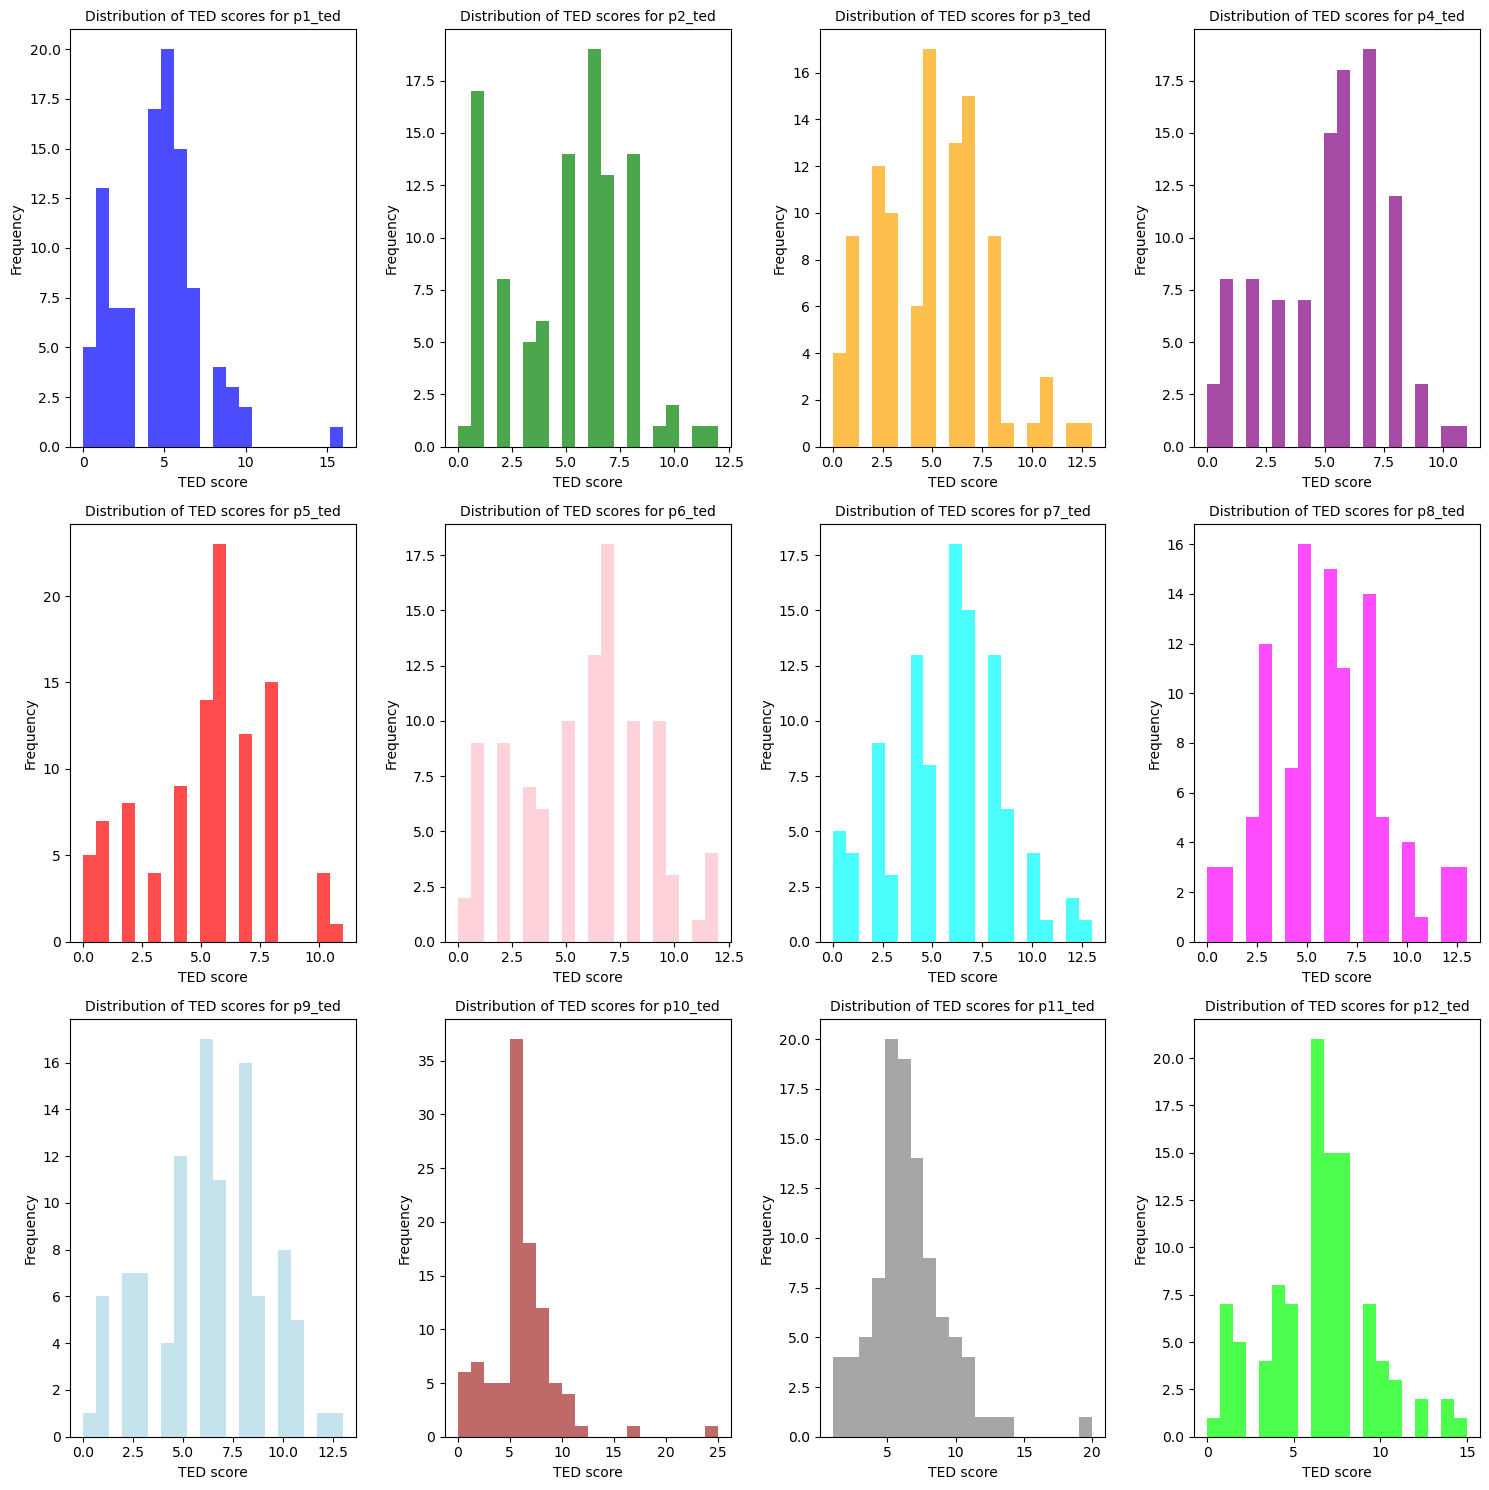

In [43]:
plot_ted_distributions(round_2_df,num_paraphrases)

#### Plot over BERT scores

In [44]:
def plot_bert_distributions(df, num_plots):
    """
    Plot the distribution of BERT scores for specified columns in the DataFrame.

    :param df: pandas DataFrame containing the BERT score columns.
    :param num_plots: Number of BERT scores columns to plot.
    """
    bert_columns = [f'p{i}_bertscore' for i in range(1, num_plots + 1)]
    num_plots = len(bert_columns)

    # Add more colors or reduce if needed, plot_colors length should be equal to num_plots
    plot_colors = ['blue', 'green', 'orange', 'purple', 'red', 'pink', 'cyan', 'magenta', 'lightblue', 'brown', 'gray', 'lime']

    num_rows = (num_plots + 3) // 4  # Calculate the number of rows needed for the grid
    fig, axs = plt.subplots(num_rows, 4, figsize=(15, 5 * num_rows))

    for i, (column, color) in enumerate(zip(bert_columns, plot_colors[:num_plots])):
        row_idx = i // 4
        col_idx = i % 4
        # Plot the distribution of BERT scores
        axs[row_idx, col_idx].hist(df[column], bins=20, color=color, alpha=0.7)
        axs[row_idx, col_idx].set_title(f'Distribution of BERT scores for {column}', fontsize=10)
        axs[row_idx, col_idx].set_xlabel('BERT score', fontsize=10)
        axs[row_idx, col_idx].set_ylabel('Frequency', fontsize=10)

    plt.tight_layout()

    # Save the plot to a file (e.g., a PDF file)
    path_to_plot_file = f"{os.getcwd()}/plots/pattern_by_example_12-threshold{ted_threshold}_BERTscores_distribution.pdf"#test_data
    plt.savefig(path_to_plot_file)

    plt.show()

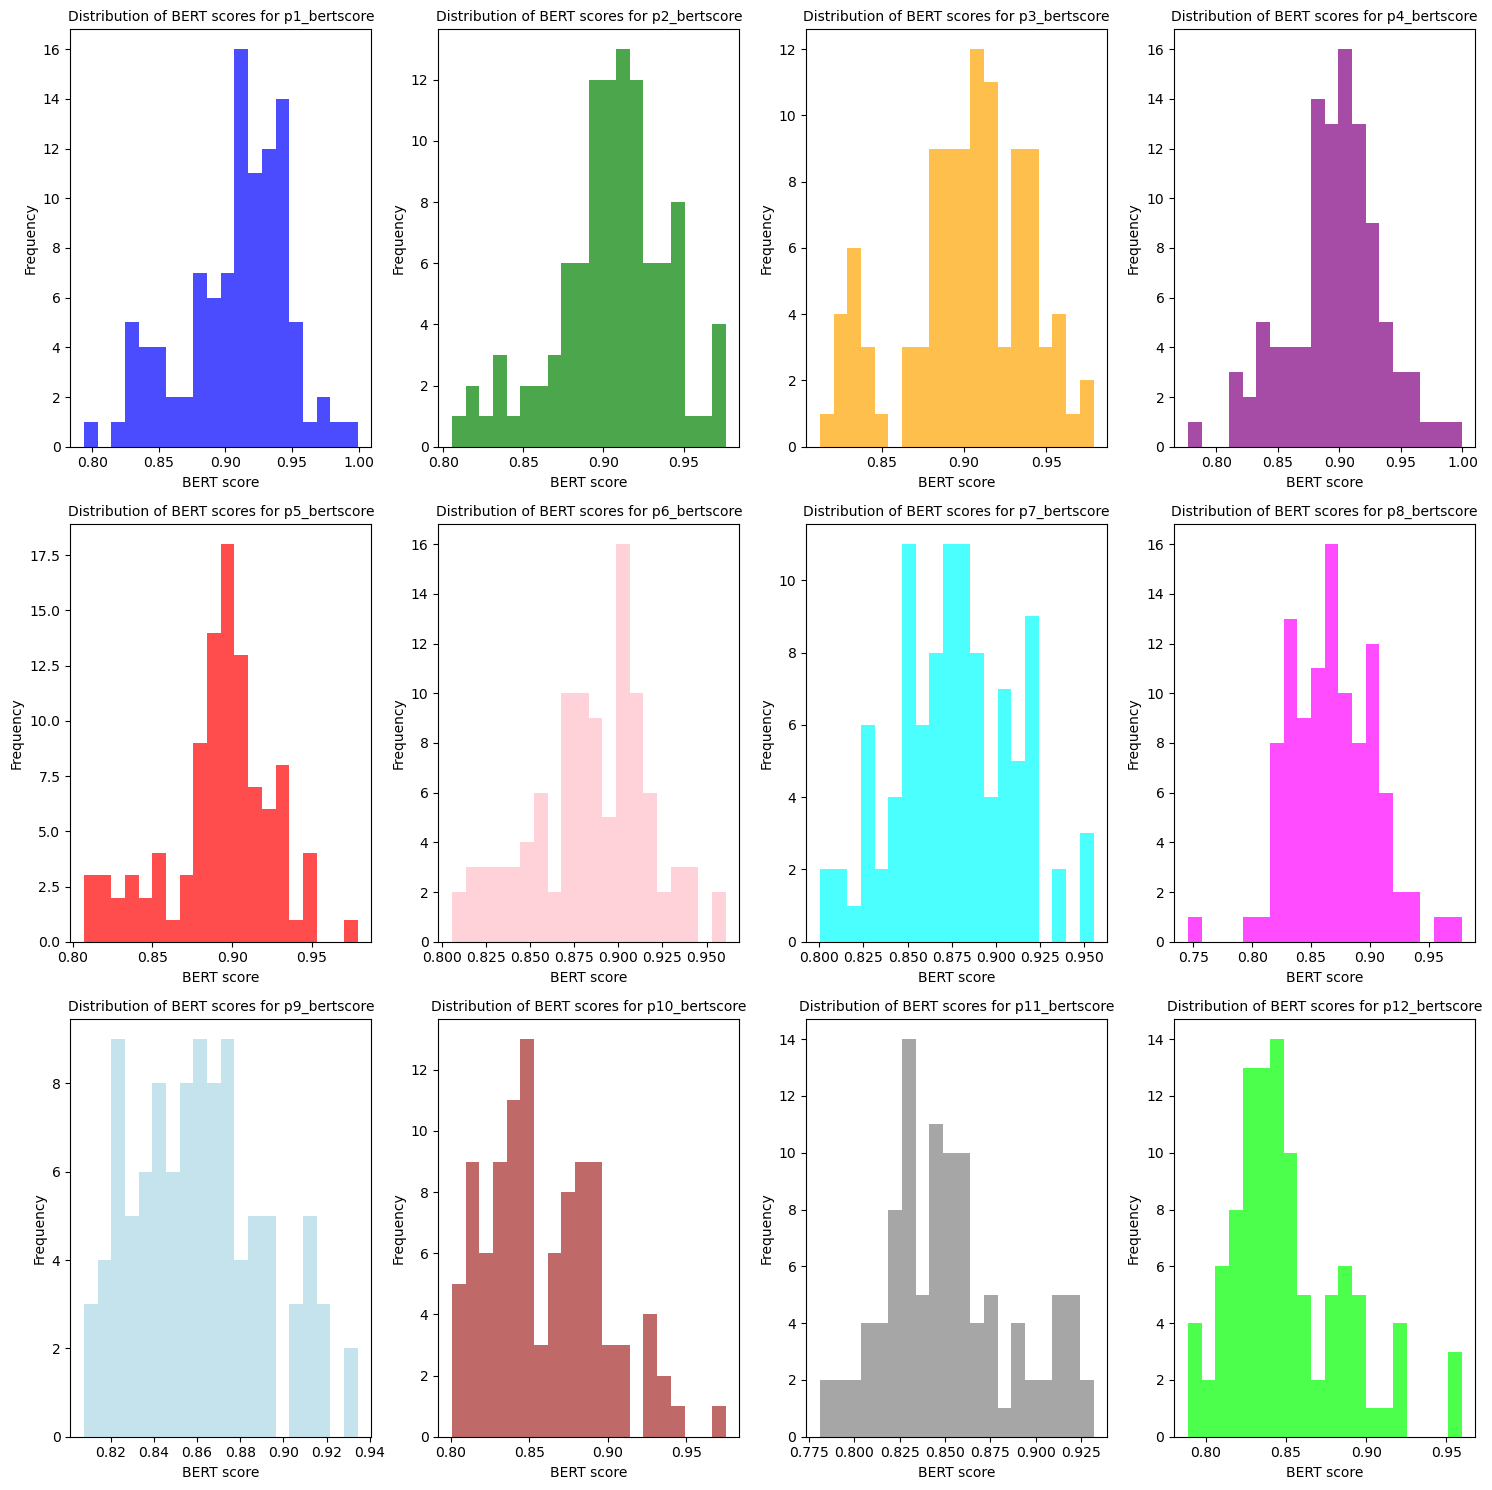

In [45]:
plot_bert_distributions(round_2_df,num_paraphrases)

In [46]:
# median judgment time for all workers and then per "paraphrase_0_notes"
p1_bertscore_median = round_2_df["p1_bertscore"].median()
p1_bertscore_mean = round_2_df["p1_bertscore"].mean()
print(f"p1_bertscore_mean: Median: {p1_bertscore_median:.4f}. Mean: {p1_bertscore_mean:.4f}.\n")

p1_bertscore_mean: Median: 0.9142. Mean: 0.9076.



#### Save the bootstrap.csv dataset

In [47]:
output_file = f"{os.getcwd()}/output/pattern_by_example_12/patterns-by-example-12-raw-correct-threshold{ted_threshold}.csv"
round_2_df.to_csv(output_file, index=False)
round_2_df.head()

,input_utterance,intent,parameters,utterance_template,source,seed_id,selected_templates,selected_templates_related_paraphrases,p1,p1_template,...,p3_ted,p4_ted,p5_ted,p6_ted,p7_ted,p8_ted,p9_ted,p10_ted,p11_ted,p12_ted
0,Terminate i-a541 now,EndEC2Instance,"[['VM', 'i-a541']]",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),ParaQuality,1,"[( S ( VP ( VB ) ( NP ) ) ), ( SQ ( MD ) ( NP ...","[define dfw, Can you find me the most recent s...",Can you terminate i-a541 immediately?,( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ...,...,1.0,2.0,1.0,1.0,7.0,2.0,6.0,5.0,3.0,3.0
1,Search for cooking videos,SearchWeb,"[['query', 'cooking videos']]",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,2,"[( S ( VP ( VB ) ( NP ) ) ), ( SQ ( MD ) ( NP ...","[Find videos on cooking, Can you find me a cop...",Look up videos about cooking,( S ( VP ( VB ) ( PRT ) ( NP ) ) ),...,7.0,4.0,4.0,5.0,6.0,7.0,6.0,6.0,6.0,7.0
2,Find most popular photos tagged #LOVE,SearchWeb,"[['Tag', '#LOVE']]",( S ( S ( VP ) ) ( VP ( VBP ) ) ),ParaQuality,3,"[( S ( VP ( VB ) ( NP ) ) ), ( SQ ( MD ) ( NP ...",[list the airlines that fly from boston to atl...,Discover the top-rated images with the #LOVE tag,( S ( VP ( VB ) ( NP ) ( PP ) ) ),...,3.0,3.0,4.0,3.0,8.0,4.0,6.0,4.0,6.0,7.0
3,Search for a few nice photos matching Opera Ho...,SearchWeb,"[['size', '1024px * 768px'], ['query', 'Opera ...",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,4,"[( S ( VP ( VB ) ( NP ) ) ), ( SQ ( MD ) ( NP ...",[find showtimes for the movie The Caretaker at...,Look up some nice Opera House pictures with di...,( S ( VP ( VB ) ( PRT ) ( NP ) ) ( . ) ),...,5.0,7.0,6.0,11.0,9.0,8.0,7.0,7.0,8.0,9.0
4,Are the burglar alarms in the office malfuncti...,CheckDevice,"[['location', 'office']]",( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,ParaQuality,5,"[( S ( VP ( VB ) ( NP ) ) ), ( SQ ( MD ) ( NP ...",[Drop a message to Phil indicating that I've g...,Are the alarms in the office for burglars not ...,( SQ ( VBP ) ( NP ( NP ) ( PP ) ( PP ) ) ( RB ...,...,8.0,7.0,8.0,7.0,12.0,10.0,12.0,11.0,5.0,8.0


### Plot syntaxtic distribution
Let's visualize the distribution of parse templates for the paraphrases of the first input utterance in the dataset.

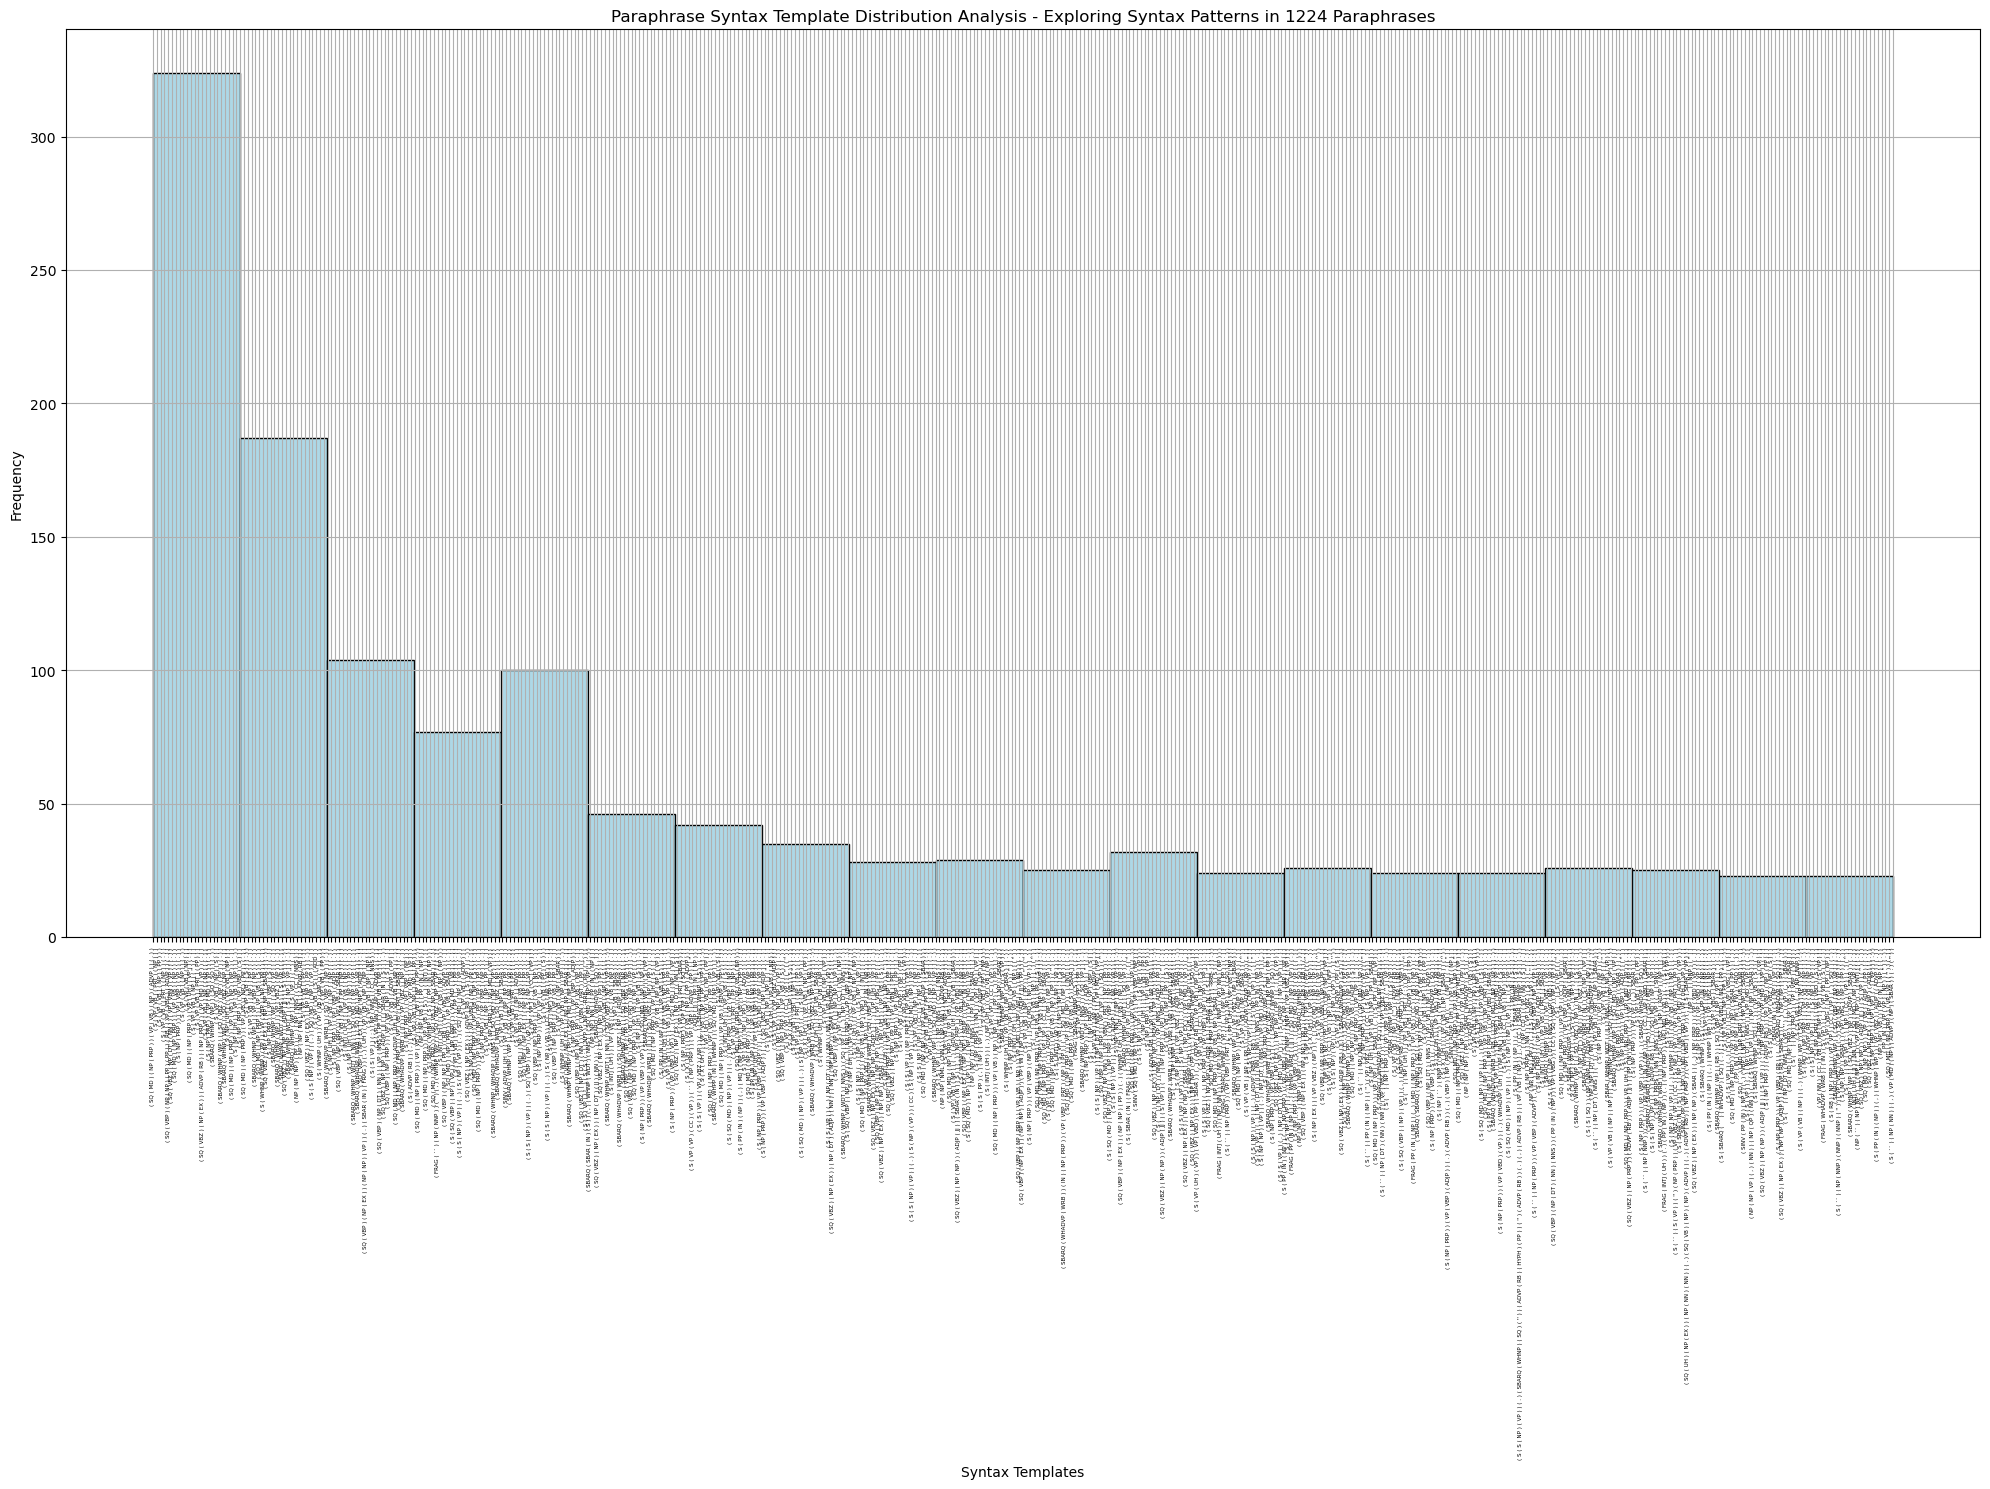

In [48]:
# Create a new column 'paraphrases_templates' by merging the values from 'p1_template', 'p2_template', and 'p3_template'
columns_2_concat = [f'p{i}_template' for i in range(1, num_paraphrases + 1)]
paraphrases_templates_df = pd.concat([round_2_df[col] for col in columns_2_concat], axis=0, ignore_index=True)

# # Rename the column to 'paraphrases_templates'
paraphrases_templates_df.columns = ['paraphrases_templates']

# Create a figure with subplots
number_of_rows = paraphrases_templates_df.shape[0]
title= f"Paraphrase Syntax Template Distribution Analysis - Exploring Syntax Patterns in {number_of_rows} Paraphrases"
plt.figure(figsize=(20, 15))
plt.hist(paraphrases_templates_df, bins=20, color='lightblue', edgecolor='black')
plt.xlabel('Syntax Templates')
plt.ylabel('Frequency')
plt.title(title)
plt.xticks(rotation='vertical', fontsize=4)
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/pattern_by_example_12-threshold-{ted_threshold}_syntax_template_distribution.pdf"#test_data
plt.savefig(path_to_plot_file)

# Optionally, display the plot on the screen
plt.show()

##### Plot syntax distribution for a pX_template columns
To plot the distribution of syntax templates for a specific column, such as 'p1_template', you can follow these steps:
1. Select the column from the DataFrame.
2. Use the value_counts() method to count the occurrences of each syntax template.
3. Plot the distribution using a bar chart.

p1_template
( S ( VP ( VB ) ( NP ) ) ( . ) )                                                                                                   8
( S ( VP ( VB ) ( NP ) ) )                                                                                                         7
( SQ ( MD ) ( NP ( PRP ) ) ( VP ( UH ) ( VP ) ) ( . ) )                                                                            6
( SBARQ ( WHNP ( WP ) ) ( SQ ( VBZ ) ( NP ) ) ( . ) )                                                                              5
( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ) ( . ) )                                                                            5
( S ( VP ( VB ) ( NP ) ( S ) ) )                                                                                                   4
( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ( PP ) ) ( . ) )                                                                     4
( SBARQ ( WHADVP ( WRB ) ) ( SQ ( MD ) ( NP ) ( VP ) ) ( 

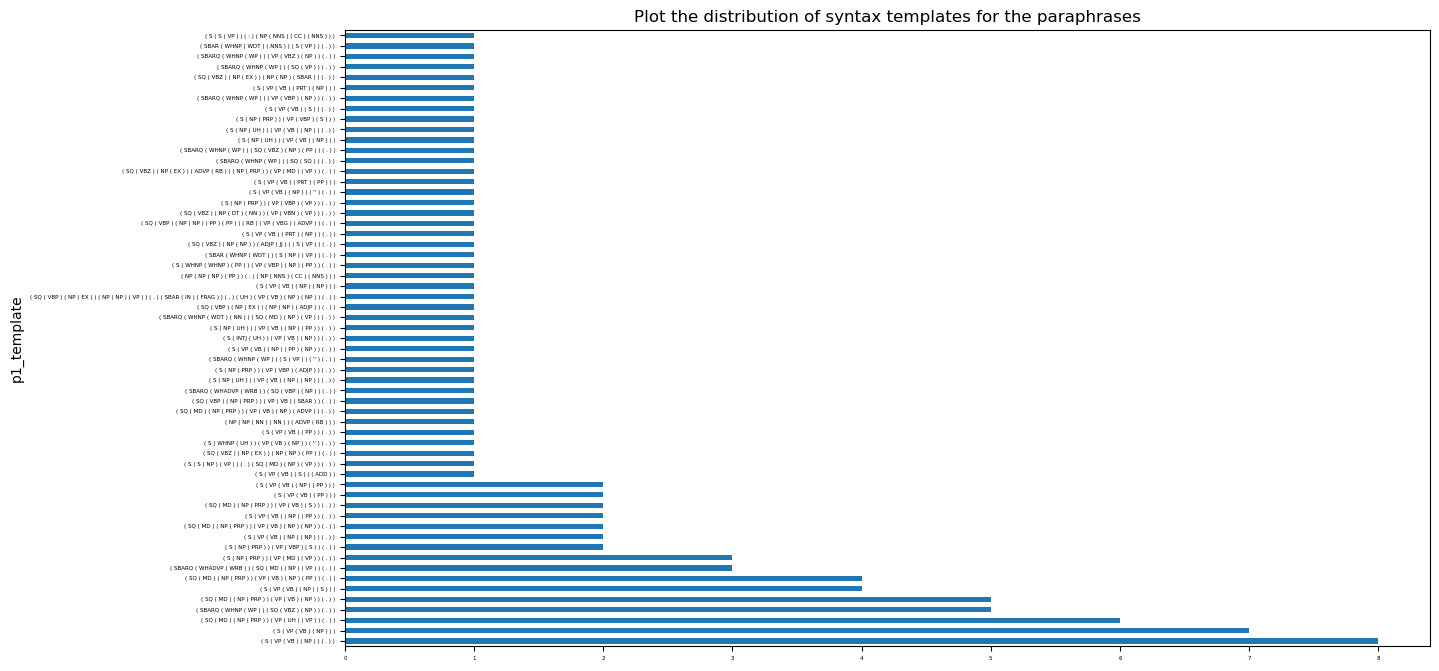

In [49]:
# Select a syntax template column between: p1_template p2_template or p3_template
round_2_df.p1_template.value_counts().plot(
    kind="barh", figsize=(14,8), fontsize=4, title=f"Plot the distribution of syntax templates for the paraphrases"
)
round_2_df.p1_template.value_counts()#count how many unique templates in p1_parse_template
# df.input_utterance.value_counts()#count how many utterance in df

### Compute metrics
To analyze the quality of paraphrases, we will calculate three metrics: DIV, TTR, and mean PINC scores.
1. `Step 1 - Data Preparation`:

   First, we will extract all correct p1, p2, and p3 paraphrases and merge the values from these three columns into a single column called "paraphrase_value." This will result in a new DataFrame with two columns: 'input_utterance' and 'paraphrase_value'.
2. `Metric Calculation`:

   Next, we will compute the DIV, TTR, and mean PINC scores for the paraphrases in the "paraphrase_value" column. These metrics will provide valuable insights into the diversity, lexical richness, and fluency of the generated paraphrases.

#### Step 1 - Data preparation

In [50]:
def extract_correct_paraphrase_templates_with_similarity(data, column_prefix):
    """
    Extracts syntax templates of correct paraphrases from the given DataFrame.

    :args
        data (DataFrame): Input DataFrame containing relevant columns.
        column_prefix (str): Prefix for the columns to be extracted.

    :returns
        correct_template_df (DataFrame): DataFrame containing extracted paraphrase templates.
    """

    columns_to_extract = [
        'input_utterance',
        'utterance_template',
        'intent',
        'seed_id',
        'source',
        f'{column_prefix}',
        f'{column_prefix}_template',
        f'{column_prefix}_bertscore',
        f'{column_prefix}_ted',
        f'{column_prefix}_duplicate',
        f'{column_prefix}_semantics',
        'selected_templates_related_paraphrases',
        f'{column_prefix}_ted_to_selected_templates',
        f'{column_prefix}_is_similar'
    ]

    # extarct only correct paraphrases df.loc[df['p1_correct'], ['input_utterance','p1','p1_template']]
    correct_template_df = data.loc[data[f'{column_prefix}_correct'], columns_to_extract]
    correct_template_df.rename(
        columns={
            f'{column_prefix}': 'paraphrase_value',
            f'{column_prefix}_template': 'paraphrase_template',
            f'{column_prefix}_bertscore': 'bertscore',
            f'{column_prefix}_ted': 'ted',
            f'{column_prefix}_duplicate': 'duplicate',
            f'{column_prefix}_semantics': 'semantics',
            f'{column_prefix}_ted_to_selected_templates': 'ted_to_selected_templates',
            f'{column_prefix}_is_similar': '_is_similar'
        },
        inplace=True
    )

    return correct_template_df

def extract_combined_series_with_similarity(data,num_paraphrases):
    """
    Extracts syntax templates of correct p1, p2, ..., pN paraphrases from the given DataFrame.

    :args
        data (DataFrame): Input DataFrame containing relevant columns.
        num_paraphrases (int): Number of paraphrase columns (p1, p2, ..., pN).

    :returns
        combined_series (Series): Concatenated Series containing extracted paraphrase data.
    """

    # Extract the syntax templates of correct pN paraphrases
    correct_p_templates = [extract_correct_paraphrase_templates_with_similarity(data, f'p{i}') for i in range(1, num_paraphrases + 1)]

    # Concatenate them into one new series called combined_series
    combined_series = pd.concat(correct_p_templates, ignore_index=True)
    
    return combined_series

In [51]:
combined_series = extract_combined_series_with_similarity(round_2_df,num_paraphrases)
combined_series.columns

Index(['input_utterance', 'utterance_template', 'intent', 'seed_id', 'source',
       'paraphrase_value', 'paraphrase_template', 'bertscore', 'ted',
       'duplicate', 'semantics', 'selected_templates_related_paraphrases',
       'ted_to_selected_templates', '_is_similar'],
      dtype='object')

In [52]:
filtered_df = combined_series[(combined_series['duplicate'] == False) & (combined_series['semantics'] == True)]
filtered_df.columns

Index(['input_utterance', 'utterance_template', 'intent', 'seed_id', 'source',
       'paraphrase_value', 'paraphrase_template', 'bertscore', 'ted',
       'duplicate', 'semantics', 'selected_templates_related_paraphrases',
       'ted_to_selected_templates', '_is_similar'],
      dtype='object')

In [53]:
output_file = f"{os.getcwd()}/output/pattern_by_example_12/patterns-by-example-12-threshold{ted_threshold}-combined_correct_only.csv"
filtered_df.to_csv(output_file, index=False)

#### Step 2 - Compute metrics

In [54]:
def compute_metrics(df, input_utterance):
    df_s = df[df["input_utterance"] == input_utterance]
    paraphrases = df_s["paraphrase_value"].values
    ttr_metric = metrics.compute_ttr(input_utterance, paraphrases)
    pincs = [metrics.compute_pinc(input_utterance, p) for p in paraphrases]
    mean_pinc = sum(pincs) / len(pincs)
    div = metrics.compute_div({input_utterance: paraphrases})
    return ttr_metric["ttr"], mean_pinc, div

def compute_metrics_for_df(df):
    ttrs = []
    mean_pincs = []
    divs = []

    for iu in df["input_utterance"].unique():
        ttr, mean_pinc, div = compute_metrics(df, iu)  # Assuming you have a function 'compute_metrics' that takes df and iu as arguments
        ttrs.append(ttr)
        mean_pincs.append(mean_pinc)
        divs.append(div)

    ttrs = np.array(ttrs)
    mean_pincs = np.array(mean_pincs)
    divs = np.array(divs)
    return ttrs, mean_pincs, divs

In [55]:
print("Compute TTR, PINC and DIV for correct paraphrases only:")
ttrs, mean_pincs, divs = compute_metrics_for_df(filtered_df)
print(f"   Mean TTR: {ttrs.mean():.4f} \n   Mean PINC: {mean_pincs.mean():.4f} \n   DIV: {divs.mean():.4f}")

print()
print("Compute TTR, PINC and DIV for all paraphrases:")
ttrs, mean_pincs, divs = compute_metrics_for_df(combined_series)
print(f"   Mean TTR: {ttrs.mean():.4f} \n   Mean PINC: {mean_pincs.mean():.4f} \n   DIV: {divs.mean():.4f}")

Compute TTR, PINC and DIV for correct paraphrases only:
   Mean TTR: 0.3998 
   Mean PINC: 0.6199 
   DIV: 0.9363

Compute TTR, PINC and DIV for all paraphrases:
   Mean TTR: 0.3998 
   Mean PINC: 0.6199 
   DIV: 0.9363


# Pattern Distribution Plot
Analyzing Patterns in Correct Paraphrases for 50 Seed Utterances. The plot showcases the frequency distribution of paraphrase patterns, specifically focusing on the correct paraphrases. After selecting the correct paraphrases, 50 Seed Utterances remain for analysis.

In [56]:
def plot_and_save_pattern_distribution(df, output_path, width=16, height=10, min_ncols=8, iu_column="input_utterance"):
    ncols = min(min_ncols, df[iu_column].value_counts().shape[0])
    nrows = math.ceil(df[iu_column].value_counts().shape[0] / ncols)
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_figwidth(width)
    fig.set_figheight(height)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.suptitle("Overall Pattern Distribution", fontsize=16)
    
    row = 0
    col = 0

    # Define a color palette for the patterns
    pattern_colors = sns.color_palette("Set1", n_colors=3)
    
    for _, input_utterance in enumerate(df[iu_column].value_counts().index.values):
        df_data = df[df[iu_column] == input_utterance]
        ax = axes[row][col] if nrows > 1 else axes[col]
        g = sns.countplot(
            x="paraphrase_template",
            data=df_data,
            order=df_data.paraphrase_template.value_counts().sort_values().index,
            ax=ax,
            palette=pattern_colors
        )
        g.set(xlabel="patterns")
        g.set(xticklabels=[])
        col += 1
        
        if col == ncols:
            col = 0
            row += 1
    
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

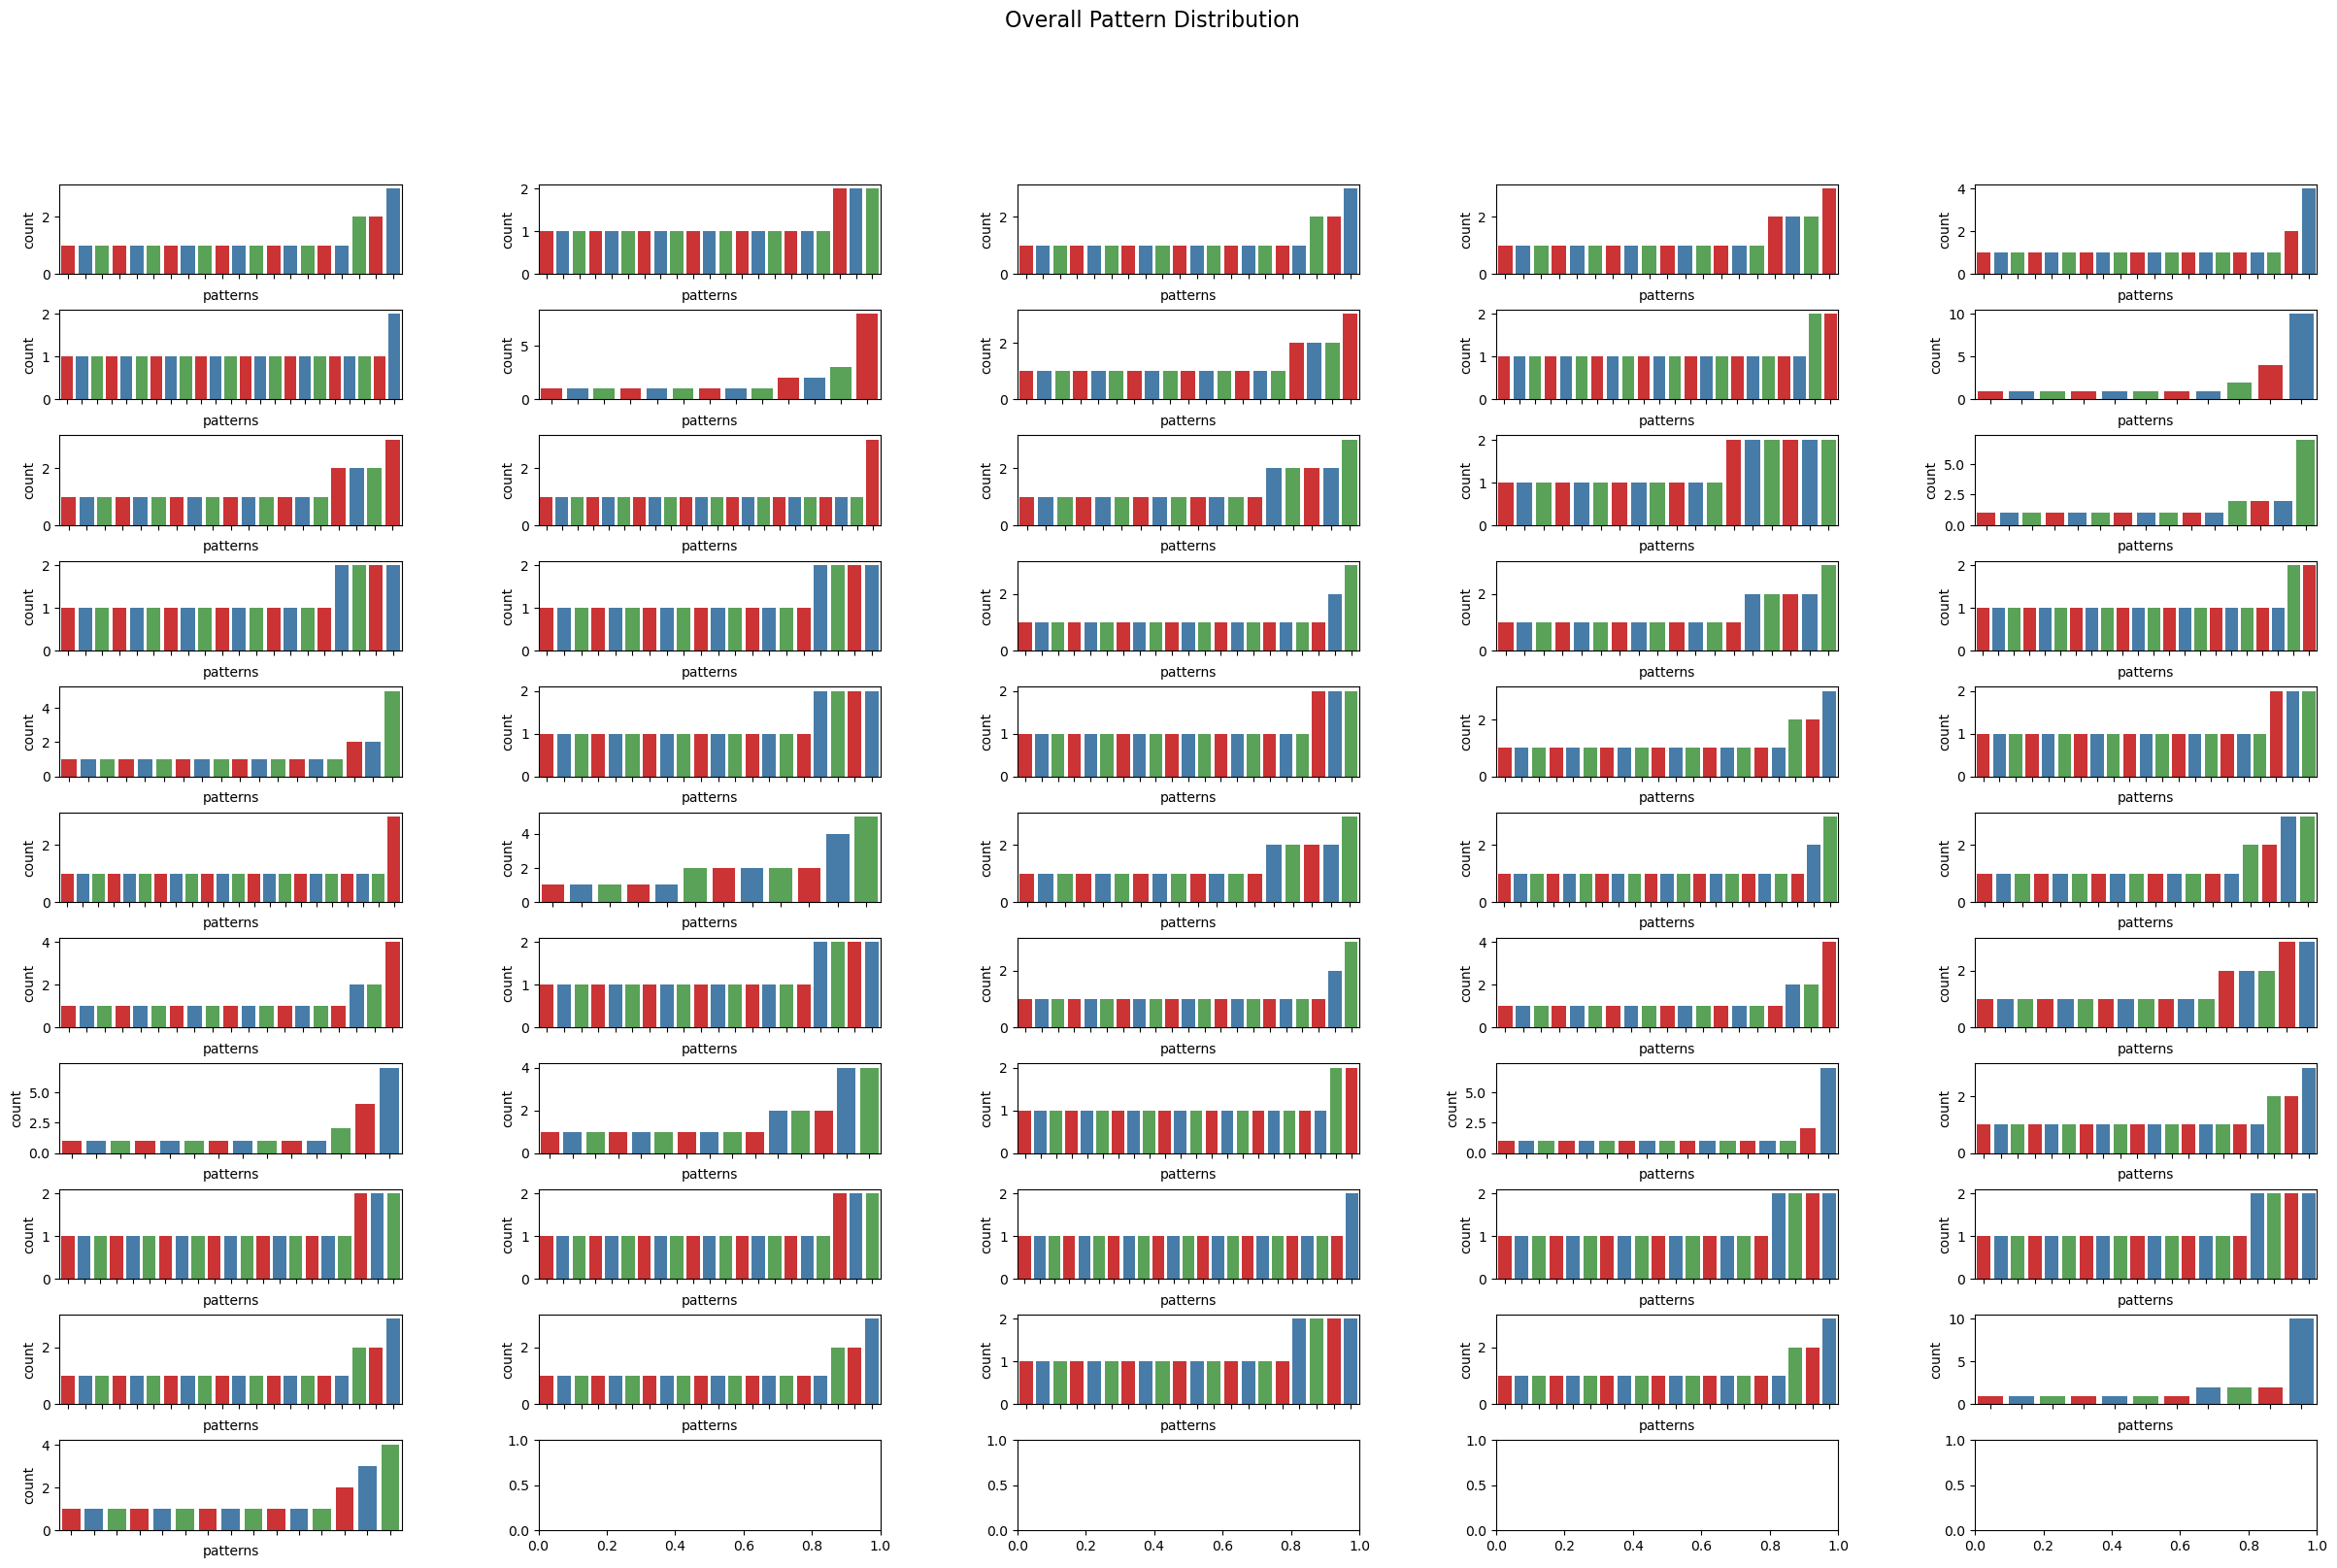

In [57]:
output_path = f"{os.getcwd()}/plots/pattern_by_example_12_threshold{ted_threshold}-pattern-distribution-correct-only.pdf"
plot_and_save_pattern_distribution(filtered_df, output_path, width=30, height=18, min_ncols=5)

In [58]:
filtered_df.paraphrase_template.unique().shape

(458,)

In [59]:
combined_series.paraphrase_template.unique().shape

(458,)

#### TED mean and median

In [60]:
print("TED mean and median for all paraphrases:")
ted_median = combined_series["ted"].median()
ted_mean = combined_series["ted"].mean()
print(f"   p1_ted: Median: {ted_median:.4f}. Mean: {ted_mean:.4f}.\n")

print("TED mean and median for correct paraphrases only:")
ted_median = filtered_df["ted"].median()
ted_mean = filtered_df["ted"].mean()
print(f"   p1_ted: Median: {ted_median:.4f}. Mean: {ted_mean:.4f}.\n")

TED mean and median for all paraphrases:
   p1_ted: Median: 6.0000. Mean: 5.6189.

TED mean and median for correct paraphrases only:
   p1_ted: Median: 6.0000. Mean: 5.6189.



## BERTscore mean and median

In [61]:
print("BERT scores mean and median for all paraphrases:")
bert_median = combined_series["bertscore"].median()
bert_mean = combined_series["bertscore"].mean()
print(f"   BERT scores: Median: {bert_median:.4f}. Mean: {bert_mean:.4f}.\n")

print("BERT scores mean and median for correct paraphrases only:")
bert_median = filtered_df["bertscore"].median()
bert_mean = filtered_df["bertscore"].mean()
print(f"   BERT scores: Median: {bert_median:.4f}. Mean: {bert_mean:.4f}.\n")

BERT scores mean and median for all paraphrases:
   BERT scores: Median: 0.8823. Mean: 0.8795.

BERT scores mean and median for correct paraphrases only:
   BERT scores: Median: 0.8823. Mean: 0.8795.



##### <div style="background-color: lightblue; padding: 10px; display: inline-block;">Statistical overview of duplicates.</div>

In [62]:
p_candidates = filtered_df.paraphrase_value.to_list()
unique_p_candidates = set(p_candidates)
num_duplicates = len(p_candidates) - len(unique_p_candidates)

print(
    "Count of recurring paraphrases, i.e., instances where paraphrases were repeatedly generated by the crowd worker, resulting in duplicates"\
    f" among the paraphrase set. For a list of {len(p_candidates)} correct paraphrases collected {num_duplicates} are duplicates."
    ""
)

Count of recurring paraphrases, i.e., instances where paraphrases were repeatedly generated by the crowd worker, resulting in duplicates among the paraphrase set. For a list of 1220 correct paraphrases collected 4 are duplicates.


##### <div style="background-color: lightblue; padding: 10px; display: inline-block;">Statistical overview per seed utterance.</div>
Count the number of duplicates paraphrases for each seed utterance.

In [64]:
duplicates_data = []

for utr in filtered_df["input_utterance"].unique():
    df_row = filtered_df[filtered_df["input_utterance"] == utr]
    p_candidates = df_row.paraphrase_value.to_list()
    unique_p_candidates = set(p_candidates)
    num_duplicates = len(p_candidates) - len(unique_p_candidates)
    duplicates_data.append({"input_utterance": utr, "num_duplicates": num_duplicates})

duplicates_data.append({"input_utterance": "Total number of duplicates in patterns-by-example", "num_duplicates": sum(d["num_duplicates"] for d in duplicates_data)})
duplicates_df = pd.DataFrame(duplicates_data)

output_file = f"{os.getcwd()}/output/pattern_by_example_12/patterns-by-example-12-threshold{ted_threshold}_duplicates_generation_stats.csv"
duplicates_df.to_csv(output_file, index=False)

duplicates_df

,input_utterance,num_duplicates
0,Terminate i-a541 now,0
1,Search for cooking videos,0
2,Find most popular photos tagged #LOVE,0
3,Search for a few nice photos matching Opera Ho...,0
4,Are the burglar alarms in the office malfuncti...,0
5,Is the TV in the house off ?,0
6,Any suggestions for an inexpensive hotel near ...,0
7,Are there any cheap hotels for 7-day stay some...,0
8,Send an email to Phil telling her that ''I got...,0
9,Give me 5 conference articles about text mining,0


##### <div style="background-color: lightblue; padding: 10px; display: inline-block;">Repetead statistical overview per syntax template.</div>
Count the number of duplicates syntax templates among paraphrases for each seed utterance.

In [65]:
duplicates_data = []

for utr in filtered_df["input_utterance"].unique():
    df_row = filtered_df[filtered_df["input_utterance"] == utr]
    p_candidates = df_row.paraphrase_template.to_list()
    unique_p_candidates = set(p_candidates)
    num_duplicates = len(p_candidates) - len(unique_p_candidates)
    duplicates_data.append({"input_utterance": utr, "num_duplicates": num_duplicates})

duplicates_data.append({"input_utterance": "Total number of duplicates in patterns-by-example", "num_duplicates": sum(d["num_duplicates"] for d in duplicates_data)})
duplicates_df = pd.DataFrame(duplicates_data)

output_file = f"{os.getcwd()}/output/pattern_by_example_12/patterns-by-example-12-threshold{ted_threshold}_duplicates_paraphrase_syntax_template_stats.csv"
duplicates_df.to_csv(output_file, index=False)

duplicates_df

,input_utterance,num_duplicates
0,Terminate i-a541 now,4
1,Search for cooking videos,12
2,Find most popular photos tagged #LOVE,7
3,Search for a few nice photos matching Opera Ho...,4
4,Are the burglar alarms in the office malfuncti...,3
5,Is the TV in the house off ?,6
6,Any suggestions for an inexpensive hotel near ...,5
7,Are there any cheap hotels for 7-day stay some...,4
8,Send an email to Phil telling her that ''I got...,3
9,Give me 5 conference articles about text mining,5


## BERTscore distribution

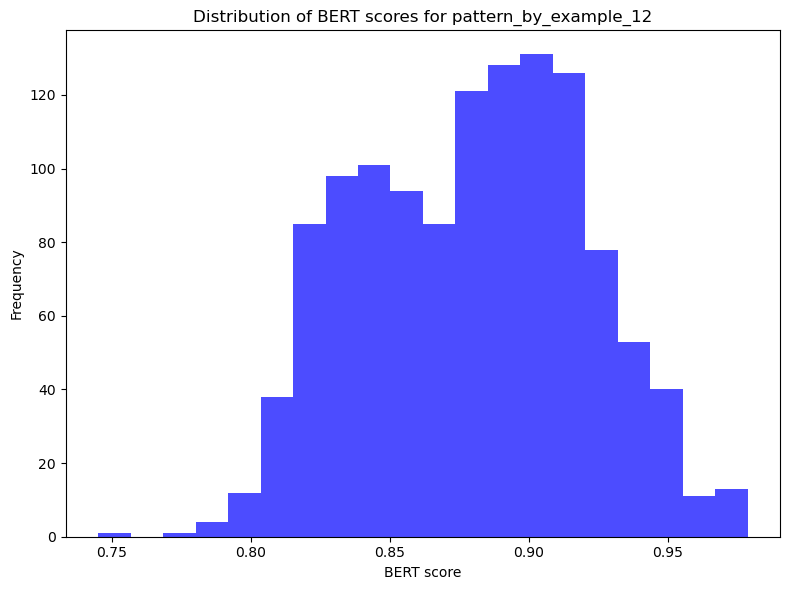

In [66]:
# Create a figure with subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of BERT scores for p1
ax.hist(filtered_df['bertscore'], bins=20, color='blue', alpha=0.7)
ax.set_title('Distribution of BERT scores for pattern_by_example_12')
ax.set_xlabel('BERT score')
ax.set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PDF file)
path_to_plot_file = f"{os.getcwd()}/plots/pattern_by_example_12_all_paraphrases-BERTscores-distribution.pdf"
plt.savefig(path_to_plot_file)

plt.show()


## TED score distribution

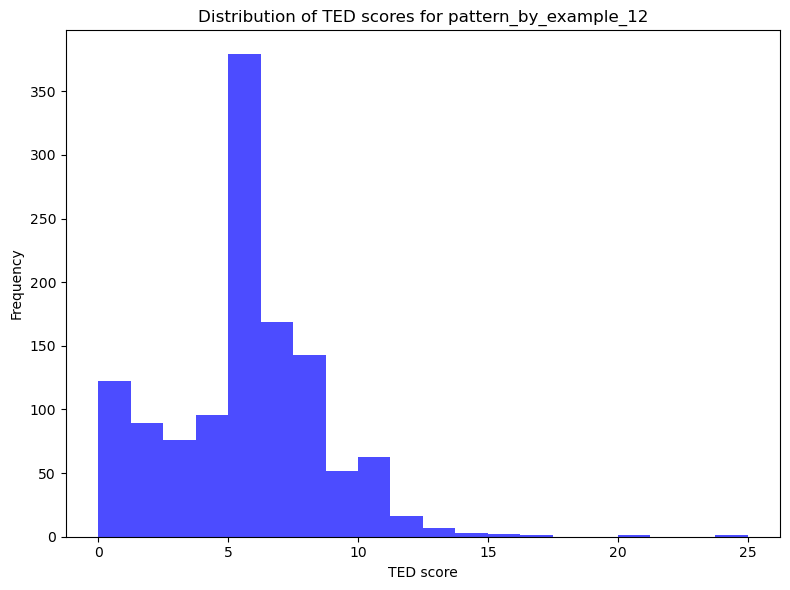

In [67]:
# Create a figure with subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of BERT scores for p1
ax.hist(filtered_df['ted'], bins=20, color='blue', alpha=0.7)
ax.set_title('Distribution of TED scores for pattern_by_example_12')
ax.set_xlabel('TED score')
ax.set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PDF file)
path_to_plot_file = f"{os.getcwd()}/plots/pattern_by_example_12_all_paraphrases-TEDscores-distribution.pdf"
plt.savefig(path_to_plot_file)

plt.show()


In [ ]:
print(f"BERT Mean: {filtered_df['bertscore'].mean()}")
print(f"BERT Median: {filtered_df['bertscore'].median()}")
print(f"BERT standard deviation: {filtered_df['bertscore'].std()}")

print(f"TED Mean: {filtered_df['ted'].mean()}")
print(f"TED Median: {filtered_df['ted'].median()}")
print(f"TED standard deviation: {filtered_df['ted'].std()}")

## <div style="background-color: #FF7276; padding: 10px;">Syntactic Novelty Analysis</div>
To explore syntactic creativity, we compile a comprehensive table indicating the count of distinct syntax templates for each seed utterance that do not appear in the bootstrap round's dataset. This provides insights into the extent of novel syntactic structures generated in subsequent rounds.

The function `get_novel_df` calculates and compiles a DataFrame that measures the novelty of paraphrase patterns in two different datasets. It assesses the uniqueness of patterns by comparing the patterns in the bootstrap (df) dataset with those in the dataset generated during this round (filtered_df). The resulting DataFrame provides information about the novelty of patterns.

In [71]:
def get_novel_df(df_main, df_boot):
    """
    Generate a DataFrame that calculates the novelty of paraphrase patterns.

    This function compares the paraphrase patterns between the main DataFrame (round 2) and the bootstrap DataFrame (round 1).
    It calculates the number of novel patterns for each condition and stores the results in a new DataFrame.

    :args
        df_main: The DataFrame generated by the current script (round 2).
        df_boot: The DataFrame generated by the bootstrap_round.ipynb script (round 1).
    
    :return
        A DataFrame containing novelty information for paraphrase patterns.
    """
    entries = []
    bootstrap_patterns = {} # row_pk => Set()
    a = []
    for row_pk in df_boot["seed_id"].unique():
        df_row = df_boot[df_boot["seed_id"] == row_pk]
        entries.append({
          "seed_id": row_pk,
          "number_unique_template_bootstrap": df_row["paraphrase_template"].nunique()
        })
        bootstrap_patterns[row_pk] = set(df_row["paraphrase_template"].unique())
    
    # add columns for main
    for entry in entries:
        row_pk = entry["seed_id"]
        df_row_cnd = df_main[(df_main["seed_id"] == row_pk)]
        entry['pattern_by_example'] = df_row_cnd["paraphrase_template"].nunique()
        row_cnd_patterns = set(df_row_cnd["paraphrase_template"].unique())
        entry[f"pattern_by_example-novel"] = len(row_cnd_patterns - bootstrap_patterns[row_pk])
    
    df_novelty = pd.DataFrame(entries, columns=["seed_id", "number_unique_template_bootstrap",'pattern_by_example','pattern_by_example-novel'])
    return df_novelty

In [72]:
df_novelty = get_novel_df(filtered_df, df)
df_novelty

,seed_id,number_unique_template_bootstrap,pattern_by_example,pattern_by_example-novel
0,1,6,22,18
1,2,4,12,8
2,3,7,16,14
3,4,8,15,12
4,5,8,20,18
5,6,10,19,16
6,7,10,20,15
7,8,14,23,16
8,9,20,22,20
9,10,11,17,12


In [73]:
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/pattern_by_example_12/pattern_by_example_workflow_syntactic_novelty.csv")
df_novelty.to_csv(path_to_plot_file, index=False)

In [74]:
# Median "novelty"
df_novelty[["number_unique_template_bootstrap","pattern_by_example","pattern_by_example-novel"]].median()

number_unique_template_bootstrap    11.0
pattern_by_example                  20.0
pattern_by_example-novel            15.0
dtype: float64

In [75]:
# Mean "novelty"
df_novelty[["number_unique_template_bootstrap","pattern_by_example","pattern_by_example-novel"]].mean()

number_unique_template_bootstrap    10.588235
pattern_by_example                  19.156863
pattern_by_example-novel            14.941176
dtype: float64

In [ ]:
# Standard Seviation "novelty"
df_novelty[["number_unique_template_bootstrap","pattern_by_example","pattern_by_example-novel"]].std()

### **Metrics all contributions**

In [76]:
def compute_metrics_condition_all(df,condition):

    ttrs = []
    mean_pincs = []
    iu_dataset = {}

    for iu in tqdm(df["input_utterance"].unique(), position=0, leave=True, desc = f"Handled input utterance for {condition}"):
        ttr, mean_pinc,_ = compute_metrics(df, iu)
        ttrs.append(ttr)
        mean_pincs.append(mean_pinc)
        iu_dataset[iu] = df[df["input_utterance"] == iu]["paraphrase_value"].values
    

    ttrs = np.array(ttrs)
    mean_pincs = np.array(mean_pincs)
    with tqdm(total=3, position=0, leave=True, desc="Calculating metrics") as pbar:
        div_score = metrics.compute_div(iu_dataset)
        pbar.update(1)
        
        bleu_score = metrics.compute_corpus_bleu(iu_dataset)
        pbar.update(1)
        
        gleu_score = metrics.compute_corpus_gleu(iu_dataset)
        pbar.update(1)
    
    return {"condition": condition, "mean_ttr": ttrs.mean(), "mean_pinc": mean_pincs.mean(), "div": div_score, 
            "bleu": bleu_score, "gleu": gleu_score, "bertscore": df.bertscore.mean()}


def get_metrics_summary_all(df, df_bootstrap):
    df_metrics = []
    df_metrics.append(compute_metrics_condition_all(df_bootstrap, "bootstrap"))
    df_metrics.append(compute_metrics_condition_all(df, "patterns_by_examples"))
    df_metrics = pd.DataFrame(df_metrics)
    return df_metrics

In [77]:
summary_all_df = get_metrics_summary_all(filtered_df,df)
summary_all_df

Calculating metrics: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.86s/it]


,condition,mean_ttr,mean_pinc,div,bleu,gleu,bertscore
0,bootstrap,0.153884,0.448408,0.745660,0.009746,0.013960,0.921994
1,patterns_by_examples,0.396735,0.624131,0.932706,0.008788,0.013298,0.878360


In [78]:
path_to_plot_file = os.path.join(os.getcwd(), f"output/summary_metric_pattern_by_example_workflow_12.csv")
summary_all_df.to_csv(path_to_plot_file, index=False)

### Count how many time TED = 0

In [18]:
TED_value = 0
count = filtered_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED_value = 1
count = filtered_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED_value = 2
count = filtered_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED_value = 3
count = filtered_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED = 0 occured 30
TED = 1 occured 92
TED = 2 occured 89
TED = 3 occured 76
